# ETL + EDA

In [1]:
import requests
import pandas as pd
from config import AUTH_KEY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import plotly.express as px
import nbformat

## Ejemplo de solicitud a la API de Datos Abiertos de la Ciudad de Buenos Aires

In [2]:
response = requests.get(f'http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/TOTAL-NACIO-DE-ACCES-48866/data.json/?auth_key={AUTH_KEY}')
data = response.json()
display(data)

{'result': {'fLength': 37,
  'fType': 'ARRAY',
  'fTimestamp': 1698149037470,
  'fArray': [{'fStr': 'Año', 'fHeader': True, 'fType': 'TEXT'},
   {'fStr': 'Trimestre', 'fHeader': True, 'fType': 'TEXT'},
   {'fStr': 'Banda ancha fija',
    'fFormat': {'fPattern': '#,###', 'fLocale': 'en-US'},
    'fHeader': True,
    'fType': 'TEXT',
    'fDisplayFormat': {'fPattern': '#,###', 'fLocale': 'es', 'fLang': 'es'}},
   {'fStr': 'Dial up',
    'fFormat': {'fPattern': '#,###', 'fLocale': 'en-US'},
    'fHeader': True,
    'fType': 'TEXT',
    'fDisplayFormat': {'fPattern': '#,###', 'fLocale': 'es', 'fLang': 'es'}},
   {'fStr': 'Total',
    'fFormat': {'fPattern': '#,###', 'fLocale': 'en-US'},
    'fHeader': True,
    'fType': 'TEXT',
    'fDisplayFormat': {'fPattern': '#,###', 'fLocale': 'es', 'fLang': 'es'}},
   {'fStr': 'Periodo', 'fHeader': True, 'fType': 'TEXT'},
   {'fStr': '2022', 'fType': 'TEXT'},
   {'fStr': '4', 'fType': 'TEXT'},
   {'fNum': 11.0,
    'fType': 'NUMBER',
    'fFormat': {

## Funciones de extracción de datos

In [3]:
def cargar_dataframe_desde_api(guid, output_format='json'):
    """
    Descarga un conjunto de datos de la API de Junar y lo carga en un DataFrame de pandas.

    Parámetros:
    - guid: El identificador único global (GUID) para el conjunto de datos deseado.
    - output_format: Formato de salida de los datos ('json' o 'csv').

    Retorna:
    - Un DataFrame de pandas con los datos del conjunto de datos.
    - None si hay algún error.
    """

    # Parámetros para la solicitud API
    params = {
        'auth_key': AUTH_KEY  # Reemplaza con tu clave de autenticación real
    }

    # Si se requiere un formato alternativo, agregarlo a los parámetros
    if output_format != 'json':
        params['output'] = output_format

    # Construye la URL de la API para obtener los detalles del conjunto de datos
    url_api_dataset = f"http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/{guid}/data.{output_format}/"

    try:
        # Hacer la solicitud a la API
        response = requests.get(url_api_dataset, params=params)

        # Asegúrate de que la solicitud fue exitosa
        if response.status_code == 200:
            data = response.json()
            # Extraer la lista de registros
            records = data.get('result', {}).get('fArray', [])
            
            # Inicializar una lista para los encabezados y los datos
            headers = []
            rows = []

            # Extraer los encabezados y los datos
            for index, record in enumerate(records):
                if 'fHeader' in record and record['fHeader']:
                    headers.append(record['fStr'])
                elif 'fStr' in record or 'fNum' in record:
                    # Asegurarse de dividir los datos en filas según la cantidad de columnas
                    position = index - len(headers)
                    row_index = position // len(headers)
                    column_index = position % len(headers)
                    # Asegurarse de que la fila exista
                    while row_index >= len(rows):
                        rows.append([])
                    # Añadir el dato a la fila correspondiente
                    rows[row_index].append(record.get('fStr', record.get('fNum', None)))

            # Crear el DataFrame
            df = pd.DataFrame(rows, columns=headers)
            return df
        else:
            print(f'Error al hacer la solicitud a la API: {response.status_code}')
            return None
    except requests.exceptions.RequestException as e:
        print(f'Error de solicitud: {e}')
        return None
    except Exception as e:
        print(f'Error al cargar los datos en el DataFrame: {e}')
        return None

# Ejemplo de uso:
# df = cargar_dataframe_desde_api('TOTAL-NACIO-DE-ACCES-48866')
# print(df)


In [4]:
def cargar_dataframe_desde_xls(url):
    """
    Descarga un conjunto de datos desde una URL y lo carga en un DataFrame de pandas.
    
    Parámetros:
    - url: La URL directa al archivo XLS para el conjunto de datos deseado.
    
    Retorna:
    - Un DataFrame de pandas con los datos del conjunto de datos.
    - None si hay algún error.
    """
    try:
        # Leer los datos en un dataframe de pandas
        df = pd.read_excel(url)
        return df
    except Exception as e:
        print(f'Error al cargar los datos en el DataFrame: {e}')
        return None

# Uso de la función
# url = 'https://datosabiertos.enacom.gob.ar/datasets/176155-penetracion-del-internet-fijo-por-provincia-accesos-por-cada-100-habitantes.download/'
# df = cargar_dataframe_desde_xls(url)
# if df is not None:
#     print(df.head())  # Muestra las primeras filas del DataFrame
# else:
#     print('No se pudo descargar el DataFrame.')


## Carga de datos

In [5]:
# Penetración de Internet fijo (accesos por cada 100 hogares)
# Número de accesos al servicio de Internet fijo por cada 100 hogares por provincia
df_penetracion_internet = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/datasets/176155-penetracion-del-internet-fijo-por-provincia-accesos-por-cada-100-habitantes.download/')

In [6]:
# Total nacional de accesos a Internet fijo por banda ancha y banda angosta
# Número total de accesos al servicio de Internet fijo por banda ancha y banda angosta (trimestral)
df_accesos_internet_nacional = cargar_dataframe_desde_api('TOTAL-NACIO-DE-ACCES-48866')

In [7]:
# Penetración por hogares nacional de Internet fijo
# Serie trimestral de la penetración del Internet fijo en la métrica por cada 100 hogares
df_penetracion_trimestral_hogares = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/rest/datastreams/291793/data.xls?applyFormat=1')

c:\Users\Compumar\Documents\Henry\PI_DA_FT16\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
# Accesos a banda ancha y banda angosta por provincia
# Número de accesos al servicio de Internet fijo por banda ancha y banda angosta en cada provincia (trimestral)
df_accesos_banda_por_provincia = cargar_dataframe_desde_api('BANDA-ANCHA-Y-BANDA-ANGOS')

In [9]:
# Serie trimestral de accesos a Internet fijo por tecnología
# Número de accesos al servicio de Internet fijo por tipo de tecnología. Total nacional (trimestral)
df_serie_trimestral_tecnologia = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/rest/datastreams/275029/data.xls?applyFormat=1')

c:\Users\Compumar\Documents\Henry\PI_DA_FT16\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [10]:
# Acceso a Internet fijo por tecnología y provincia
# Número de accesos al servicio de Internet fijo por tipo de tecnología en cada provincia (trimestral)
df_acceso_internet_tecnologia_provincia = cargar_dataframe_desde_api('ACCES-A-INTER-FIJO-POR')

In [11]:
# Velocidad Media de bajada de Internet fijo
# Serie histórica de la velocidad media de descarga de Internet nacional (trimestral)
df_velocidad_descarga_media = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/rest/datastreams/288059/data.xls?applyFormat=1')

c:\Users\Compumar\Documents\Henry\PI_DA_FT16\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
# Distribución de los accesos totales nacionales a Internet fijo por velocidad
# Distribución de los accesos totales nacionales a Internet fijo por velocidad de bajada (último trimestre disponible)
df_distribucion_velocidad_accesos = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/rest/datastreams/291791/data.xls?applyFormat=1')


c:\Users\Compumar\Documents\Henry\PI_DA_FT16\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [13]:
# Acceso a Internet Fijo por rangos de velocidad de bajada y provincia
# Número de accesos al servicio de Internet fijo por velocidad de bajada en cada provincia (trimestral)

df_accesos_rango_velocidad_provincia = cargar_dataframe_desde_api('ACCES-A-INTER-FIJO-23248')

Error al cargar los datos en el DataFrame: integer division or modulo by zero


In [14]:
# Ingresos trimestrales por la prestación del servicio de Internet fijo
# Ingresos trimestrales de los operadores por el servicio de Internet fijo
df_ingresos_trimestrales_internet = cargar_dataframe_desde_xls('https://datosabiertos.enacom.gob.ar/rest/datastreams/275023/data.xls?applyFormat=1')

c:\Users\Compumar\Documents\Henry\PI_DA_FT16\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [15]:
# Accesos a Internet fijo por velocidad de bajada y localidad
# Número de accesos al servicio de Internet fijo por velocidad de bajada en cada localidad declarada

df_accesos_velocidad_localidad = cargar_dataframe_desde_api('ACCES-A-INTER-FIJO-16249')

In [16]:
# Accesos a Internet fijo por tecnología y localidad
# Número de accesos al servicio de Internet fijo por tecnología en cada localidad declarada Categoría

df_accesos_tecnologia_localidad = cargar_dataframe_desde_api('ACCES-A-INTER-FIJO-62463')

In [17]:
# Listado de localidades con conectividad a internet.
# Listado de localidades con conectividad a internet, con detalle por tipo de conexión.

df_listado_localidades_conectividad = cargar_dataframe_desde_api('LISTA-DE-LOCAL-CON-CONEC')

In [18]:
dataframes_dict = {
    'Penetración de Internet': df_penetracion_internet,
    'Accesos a Internet Nacional': df_accesos_internet_nacional,
    'Penetración Trimestral en Hogares': df_penetracion_trimestral_hogares,
    'Accesos de Banda Ancha por Provincia': df_accesos_banda_por_provincia,
    'Serie Trimestral por Tecnología': df_serie_trimestral_tecnologia,
    'Acceso a Internet por Tecnología y Provincia': df_acceso_internet_tecnologia_provincia,
    'Velocidad de Descarga Media': df_velocidad_descarga_media,
    'Distribución de Velocidades de Acceso': df_distribucion_velocidad_accesos,
    'Accesos por Rango de Velocidad y Provincia': df_accesos_rango_velocidad_provincia,
    'Ingresos Trimestrales de Internet': df_ingresos_trimestrales_internet,
    'Accesos por Velocidad y Localidad': df_accesos_velocidad_localidad,
    'Accesos por Tecnología y Localidad': df_accesos_tecnologia_localidad,
    'Listado de Localidades con Conectividad': df_listado_localidades_conectividad
}


## Análisis Exploratorio de Datos

Esta función es util para realizar un análisis básico inicial. 

In [19]:

def informacion_dataframe(nombre, df, visualizar=True, muestras=None, interactividad=False):
    """
    Imprime la información general, estadísticas descriptivas, y las primeras y últimas filas de un DataFrame.
    Genera visualizaciones para las variables numéricas para entender su distribución y relaciones.
    
    Parámetros:
    - nombre (str): Nombre descriptivo del DataFrame para imprimir.
    - df (pd.DataFrame): DataFrame del cual se obtendrá y mostrará la información.
    - visualizar (bool): Si se generarán o no visualizaciones.
    - muestras (int): Número de muestras a visualizar si el DataFrame es muy grande.
    - interactividad (bool): Si las visualizaciones deben ser interactivas (Plotly) o estáticas (Matplotlib).
    """
    
    print(f"Analizando: {nombre}")
    
    if not isinstance(df, pd.DataFrame):
        print("El argumento proporcionado no es un DataFrame válido.")
        return
    
    print("Información General del DataFrame:")
    print(df.info())
    
    print("\nEstadísticas Descriptivas:")
    print(df.describe(include='all'))
    
    print("\nTipos de datos de las columnas:")
    print(df.dtypes)

    print("\nPrimeras y últimas filas del DataFrame:")
    display(pd.concat([df.head(), df.tail()]))
    
    print("\nValores nulos por columna:")
    null_info = df.isnull().sum()
    null_percent = (null_info / len(df)) * 100
    null_df = pd.DataFrame({'Cantidad': null_info, 'Porcentaje': null_percent})
    print(null_df)

    print("\nNúmero de filas duplicadas:", df.duplicated().sum())
    
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
        print(f"\nNúmero de valores únicos en '{col}':", df[col].nunique())
        print(f"Valor más común en '{col}':", df[col].mode().iloc[0])

    if visualizar:
        df_viz = df.sample(n=muestras, random_state=1) if muestras and len(df) > muestras else df
        
        for col in num_cols:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(df_viz[col], kde=True)
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.title(f'Histograma de {col}')
            plt.subplot(1, 2, 2)
            sns.boxplot(x=df_viz[col])
            plt.xlabel(col)
            plt.title(f'Boxplot de {col}')
            plt.tight_layout()
            plt.show()

        for col in cat_cols:
            plt.figure(figsize=(10, 4))
            sns.countplot(x=col, data=df_viz)
            plt.xlabel(col)
            plt.ylabel('Conteo')
            plt.title(f'Distribución de {col}')
            plt.tight_layout()
            plt.show()

        sns.heatmap(df_viz.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de Calor de Valores Nulos')
        plt.xlabel('Columnas')
        plt.ylabel('Registros')
        plt.show()

        if len(num_cols) > 1:
            correlation_matrix = df_viz[num_cols].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
            plt.title('Matriz de Correlación de Variables Numéricas')
            plt.xlabel('Variables')
            plt.ylabel('Variables')
            plt.show()
            
        if interactividad:
            for col in num_cols:
                fig = px.histogram(df_viz, x=col)
                fig.update_layout(title=f'Histograma de {col}', xaxis_title=col, yaxis_title='Frecuencia')
                fig.show()
                fig = px.box(df_viz, y=col)
                fig.update_layout(title=f'Boxplot de {col}', xaxis_title=col, yaxis_title='Valor')
                fig.show()
            
            for col in cat_cols:
                conteos = df_viz[col].value_counts().reset_index()
                conteos.columns = ['categoria', 'conteo']
                fig = px.bar(conteos, x='categoria', y='conteo')
                fig.update_layout(title=f'Distribución de {col}', xaxis_title='Categoría', yaxis_title='Conteo')
                fig.show()

    print("#" * 50)  # Separador visual



In [20]:

# Iterar sobre los elementos del diccionario para mostrar su información
for nombre, df in dataframes_dict.items():
    informacion_dataframe(nombre, df, visualizar=False, muestras=None, interactividad=False)



Analizando: Penetración de Internet
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Año                       864 non-null    int64  
 1   Trimestre                 864 non-null    int64  
 2   Provincia                 864 non-null    object 
 3   Accesos por cada 100 hab  864 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.1+ KB
None

Estadísticas Descriptivas:
                Año   Trimestre     Provincia  Accesos por cada 100 hab
count    864.000000  864.000000           864                864.000000
unique          NaN         NaN            24                       NaN
top             NaN         NaN  Buenos Aires                       NaN
freq            NaN         NaN            36                       NaN
mean    2018.000000    2.500000        

Año  Trimestre            Provincia  Accesos por cada 100 hab
0    2022          4         Buenos Aires                 26.720000
1    2022          4      Capital Federal                 50.350000
2    2022          4            Catamarca                 16.730000
3    2022          4                Chaco                 11.660000
4    2022          4               Chubut                 26.230000
859  2014          1           Santa Cruz                  8.677327
860  2014          1             Santa Fe                 15.077801
861  2014          1  Santiago Del Estero                  4.058899
862  2014          1     Tierra Del Fuego                 19.104921
863  2014          1              Tucumán                  8.307215


Valores nulos por columna:
                          Cantidad  Porcentaje
Año                              0         0.0
Trimestre                        0         0.0
Provincia                        0         0.0
Accesos por cada 100 hab         0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': Buenos Aires
##################################################
Analizando: Accesos a Internet Nacional
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               36 non-null     object 
 1   Trimestre         36 non-null     object 
 2   Banda ancha fija  36 non-null     float64
 3   Dial up           36 non-null     float64
 4   Total             36 non-null     float64
 5   Periodo           36 non-null     object 
dtypes: floa

Año Trimestre  Banda ancha fija  Dial up  Total        Periodo
0   2022         4              11.0     12.0   11.0   Oct-Dic 2022
1   2022         3              11.0     12.0   11.0  Jul-Sept 2022
2   2022         2              11.0     12.0   11.0   Abr-Jun 2022
3   2022         1              11.0     13.0   11.0   Ene-Mar 2022
4   2021         4              10.0     13.0   10.0   Oct-Dic 2021
31  2015         1               7.0     38.0    7.0   Ene-Mar 2015
32  2014         4               7.0     39.0    7.0   Oct-Dic 2014
33  2014         3               7.0     36.0    7.0  Jul-Sept 2014
34  2014         2               6.0     36.0    6.0   Abr-Jun 2014
35  2014         1               6.0     36.0    6.0   Ene-Mar 2014


Valores nulos por columna:
                  Cantidad  Porcentaje
Año                      0         0.0
Trimestre                0         0.0
Banda ancha fija         0         0.0
Dial up                  0         0.0
Total                    0         0.0
Periodo                  0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Año': 9
Valor más común en 'Año': 2014

Número de valores únicos en 'Trimestre': 4
Valor más común en 'Trimestre': 1

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014
##################################################
Analizando: Penetración Trimestral en Hogares
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Año                           36 non-null     int64 
 1   Trimestre             

Año  Trimestre Accesos por cada 100 hogares Accesos por cada 100 hab  \
0   2022          4                        77,21                    24,15   
1   2022          3                        76,64                    23,95   
2   2022          2                        75,97                    23,72   
3   2022          1                        73,88                    23,05   
4   2021          4                        73,18                    22,81   
31  2015          1                        51,36                    15,68   
32  2014          4                        50,50                    15,39   
33  2014          3                        50,67                    15,43   
34  2014          2                        49,86                    15,16   
35  2014          1                        49,55                    15,05   

          Periodo  
0    Oct-Dic 2022  
1   Jul-Sept 2022  
2    Abr-Jun 2022  
3    Ene-Mar 2022  
4    Oct-Dic 2021  
31   Ene-Mar 2015  
32   Oct-Dic 2014  
33  Jul-Sept 2014  
34   Abr-Jun 2014  
35   Ene-Mar 2014


Valores nulos por columna:
                              Cantidad  Porcentaje
Año                                  0         0.0
Trimestre                            0         0.0
Accesos por cada 100 hogares         0         0.0
Accesos por cada 100 hab             0         0.0
Periodo                              0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Accesos por cada 100 hogares': 36
Valor más común en 'Accesos por cada 100 hogares': 49,55

Número de valores únicos en 'Accesos por cada 100 hab': 36
Valor más común en 'Accesos por cada 100 hab': 15,05

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014
##################################################
Analizando: Accesos de Banda Ancha por Provincia
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            ------

Año Trimestre            Provincia  Banda ancha fija Dial up  Total
0    2022         4         Buenos Aires               5.0     6.0    5.0
1    2022         4      Capital Federal               2.0     2.0    2.0
2    2022         4            Catamarca              71.0     1.0   71.0
3    2022         4                Chaco             144.0     5.0  144.0
4    2022         4               Chubut             168.0   904.0  169.0
859  2014         1           Santa Cruz              26.0   460.0   27.0
860  2014         1             Santa Fe             506.0   612.0  507.0
861  2014         1  Santiago Del Estero              37.0     9.0   37.0
862  2014         1     Tierra Del Fuego              27.0   766.0   28.0
863  2014         1              Tucumán             130.0    88.0  130.0


Valores nulos por columna:
                  Cantidad  Porcentaje
Año                      0         0.0
Trimestre                0         0.0
Provincia                0         0.0
Banda ancha fija         0         0.0
Dial up                  0         0.0
Total                    0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Año': 9
Valor más común en 'Año': 2014

Número de valores únicos en 'Trimestre': 4
Valor más común en 'Trimestre': 1

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': Buenos Aires

Número de valores únicos en 'Dial up': 201
Valor más común en 'Dial up': 2.0
##################################################
Analizando: Serie Trimestral por Tecnología
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Año           36 non-null     in

Año  Trimestre  ADSL  Cablemodem  Fibra óptica  Wireless  Otros  Total  \
0   2022          4     1           6             3       573    222     11   
1   2022          3     1           6             3       557    235     11   
2   2022          2     1           6             3       556    232     11   
3   2022          1     2           6             2       546    252     11   
4   2021          4     2           6             2       523    253     10   
31  2015          1     4           3           168        79     66      7   
32  2014          4     4           3           150        77     72      7   
33  2014          3     4           3           155        85     70      7   
34  2014          2     4           2           149        72     72      6   
35  2014          1     4           2           150        71     73      6   

          Periodo  
0    Oct-Dic 2022  
1   Jul-Sept 2022  
2    Abr-Jun 2022  
3    Ene-Mar 2022  
4    Oct-Dic 2021  
31   Ene-Mar 2015  
32   Oct-Dic 2014  
33  Jul-Sept 2014  
34   Abr-Jun 2014  
35   Ene-Mar 2014


Valores nulos por columna:
              Cantidad  Porcentaje
Año                  0         0.0
Trimestre            0         0.0
ADSL                 0         0.0
Cablemodem           0         0.0
Fibra óptica         0         0.0
Wireless             0         0.0
Otros                0         0.0
Total                0         0.0
Periodo              0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014
##################################################
Analizando: Acceso a Internet por Tecnología y Provincia
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Año           865 non-null    object
 1   Trimestre     865 non-null    object
 2   Provincia     865 non-null    object
 3   ADSL          865 non-null    object
 4   C

Año                                          Trimestre  \
0    2022                                                  4   
1    2022                                                  4   
2    2022                                                  4   
3    2022                                                  4   
4    2022                                                  4   
860  2014                                                  1   
861  2014                                                  1   
862  2014                                                  1   
863  2014                                                  1   
864     *  Los datos provinciales no coinciden a nivel na...   

               Provincia   ADSL Cablemodem Fibra óptica Wireless  Otros  Total  
0           Buenos Aires  326.0        3.0          1.0    130.0   72.0    5.0  
1        Capital Federal  139.0        1.0        139.0      5.0   32.0    2.0  
2              Catamarca    9.0       11.0         47.0      1.0    2.0   71.0  
3                  Chaco   25.0       61.0         47.0      8.0    3.0  144.0  
4                 Chubut   45.0       74.0         10.0     31.0    9.0  169.0  
860             Santa Fe  323.0      174.0          3.0      6.0  644.0  507.0  
861  Santiago Del Estero   33.0        4.0         19.0    915.0   34.0   37.0  
862     Tierra Del Fuego   22.0        3.0        648.0      1.0    3.0   28.0  
863              Tucumán  130.0       83.0        121.0     13.0   98.0  130.0  
864


Valores nulos por columna:
              Cantidad  Porcentaje
Año                  0         0.0
Trimestre            0         0.0
Provincia            0         0.0
ADSL                 0         0.0
Cablemodem           0         0.0
Fibra óptica         0         0.0
Wireless             0         0.0
Otros                0         0.0
Total                0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Año': 11
Valor más común en 'Año': 2014

Número de valores únicos en 'Trimestre': 8
Valor más común en 'Trimestre': 4

Número de valores únicos en 'Provincia': 25
Valor más común en 'Provincia': Buenos Aires

Número de valores únicos en 'ADSL': 197
Valor más común en 'ADSL': 11.0

Número de valores únicos en 'Cablemodem': 218
Valor más común en 'Cablemodem': 1.0

Número de valores únicos en 'Fibra óptica': 253
Valor más común en 'Fibra óptica': 1.0

Número de valores únicos en 'Wireless': 127
Valor más común en 'Wireless': 1.0

Número de valores únicos en

Año  Trimestre  Mbps (Media de bajada)    Trimestre.1
0   2022          4                   10656   Oct-Dic 2022
1   2022          3                    6246  Jul-Sept 2022
2   2022          2                    5844   Abr-Jun 2022
3   2022          1                    5511   Ene-Mar 2022
4   2021          4                    5234   Oct-Dic 2021
31  2015          1                     435   Ene-Mar 2015
32  2014          4                     416   Oct-Dic 2014
33  2014          3                     387  Jul-Sept 2014
34  2014          2                     376   Abr-Jun 2014
35  2014          1                     362   Ene-Mar 2014


Valores nulos por columna:
                        Cantidad  Porcentaje
Año                            0         0.0
Trimestre                      0         0.0
Mbps (Media de bajada)         0         0.0
Trimestre.1                    0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Trimestre.1': 36
Valor más común en 'Trimestre.1': Abr-Jun 2014
##################################################
Analizando: Distribución de Velocidades de Acceso
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Año                      36 non-null     int64  
 1   Trimestre                36 non-null     int64  
 2   Hasta 512 kbps           36 non-null     float64
 3   Entre 512 Kbps y 1 Mbps  36 non-null     float64
 4   Entre 1 Mbps y 6 Mbps    36 non-null     object 
 5   

Año  Trimestre  Hasta 512 kbps  Entre 512 Kbps y 1 Mbps  \
0   2022          4          31.981                   85.668   
1   2022          3          33.013                   96.727   
2   2022          2          33.667                   99.498   
3   2022          1          34.890                  104.840   
4   2021          4          41.262                   28.521   
31  2015          1          41.158                  516.919   
32  2014          4          44.075                  554.749   
33  2014          3          37.430                  608.018   
34  2014          2          41.064                  656.408   
35  2014          1          52.684                  687.619   

   Entre 1 Mbps y 6 Mbps Entre 6 Mbps y 10 Mbps Entre 10 Mbps y 20 Mbps  \
0              1.075.272              1.109.421                 765.015   
1              1.161.370              1.151.906                 823.505   
2              1.193.090              1.197.030                 856.562   
3              1.263.273              1.209.148                 967.508   
4              1.413.208              1.245.333                 976.539   
31             5.121.423                571.620                 348.102   
32             5.084.556                496.251                 276.254   
33             5.153.437                373.372                 182.483   
34             5.149.574                341.689                 147.273   
35             5.130.294                289.182                 101.127   

   Entre 20 Mbps y 30 Mbps Más de 30 Mbps    OTROS       Total  
0                  335.573      7.410.902  394.282  11.208.114  
1                  479.822      6.995.750  349.035  11.091.128  
2                  485.321      6.741.922  351.594  10.958.684  
3                  509.830      6.336.187  198.333  10.624.009  
4                  558.358      6.032.322  194.251  10.489.794  
31                   7.643         16.347    0.000   6.623.212  
32                   4.371         15.229    0.000   6.475.485  
33                     507         12.424    0.000   6.367.671  
34                     478         12.259    0.000   6.348.745  
35                     345         11.595    0.000   6.272.846


Valores nulos por columna:
                         Cantidad  Porcentaje
Año                             0         0.0
Trimestre                       0         0.0
Hasta 512 kbps                  0         0.0
Entre 512 Kbps y 1 Mbps         0         0.0
Entre 1 Mbps y 6 Mbps           0         0.0
Entre 6 Mbps y 10 Mbps          0         0.0
Entre 10 Mbps y 20 Mbps         0         0.0
Entre 20 Mbps y 30 Mbps         0         0.0
Más de 30 Mbps                  0         0.0
OTROS                           0         0.0
Total                           0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Entre 1 Mbps y 6 Mbps': 36
Valor más común en 'Entre 1 Mbps y 6 Mbps': 1.075.272

Número de valores únicos en 'Entre 6 Mbps y 10 Mbps': 36
Valor más común en 'Entre 6 Mbps y 10 Mbps': 1.005.545

Número de valores únicos en 'Entre 10 Mbps y 20 Mbps': 36
Valor más común en 'Entre 10 Mbps y 20 Mbps': 1.038.029

Número de valores únicos en 'Entre 20 Mbps y 30 M

Año  Trimestre  Ingresos (miles de pesos)        Periodo
0   2022          4                         72   Oct-Dic 2022
1   2022          3                         64  Jul-Sept 2022
2   2022          2                         60   Abr-Jun 2022
3   2022          1                         55   Ene-Mar 2022
4   2021          4                         45   Oct-Dic 2021
31  2015          1                          5   Ene-Mar 2015
32  2014          4                          4   Oct-Dic 2014
33  2014          3                          3  Jul-Sept 2014
34  2014          2                          3   Abr-Jun 2014
35  2014          1                          3   Ene-Mar 2014


Valores nulos por columna:
                           Cantidad  Porcentaje
Año                               0         0.0
Trimestre                         0         0.0
Ingresos (miles de pesos)         0         0.0
Periodo                           0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014
##################################################
Analizando: Accesos por Velocidad y Localidad
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 83 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Provincia   3095 non-null   object
 1   Partido     3095 non-null   object
 2   Localidad   3095 non-null   object
 3   Link Indec  3095 non-null   object
 4   Otros       3095 non-null   object
 5   0,256 Mbps  3095 non-null   object
 6   0,375 Mbps  3095 non-null   object
 7   0,5 Mbps   

Provincia      Partido                           Localidad  \
0     BUENOS AIRES   25 de Mayo                          25 de Mayo   
1     BUENOS AIRES   25 de Mayo                     Agustín Mosconi   
2     BUENOS AIRES   25 de Mayo                           Del Valle   
3     BUENOS AIRES   25 de Mayo                           Ernestina   
4     BUENOS AIRES   25 de Mayo                   Gobernador Ugarte   
3090       TUCUMAN   Tafí Viejo  Villa Mariano Moreno - El Colmenar   
3091       TUCUMAN      Trancas                San Pedro de Colalao   
3092       TUCUMAN      Trancas                   Villa  de Trancas   
3093       TUCUMAN  Yerba Buena                       Villa Carmela   
3094       TUCUMAN  Yerba Buena            Yerba Buena - Marcos Paz   

     Link Indec Otros 0,256 Mbps 0,375 Mbps 0,5 Mbps 0,512 Mbps 0,625 Mbps  \
0       6854100                                    2                         
1       6854010                                                              
2       6854020                                    1                         
3       6854030                                                              
4       6854040                                                              
3090   90105100                                                              
3091   90112020                                                              
3092   90112030     4                                                        
3093   90119020                                                              
3094   90119030   176                                                        

      ... 61 Mbps 62 Mbps 64 Mbps 65 Mbps 66 Mbps 70 Mbps 75 Mbps 78 Mbps  \
0     ...                                                                   
1     ...                                                                   
2     ...                                                                   
3     ...                                                                   
4     ...                               1                                   
3090  ...                                                                   
3091  ...                                                                   
3092  ...                                                                   
3093  ...                                                                   
3094  ...                                                                   

     80 Mbps 83 Mbps  
0         12          
1                     
2                     
3                     
4                     
3090                  
3091                  
3092                  
3093                  
3094                  

[10 rows x 83 columns]


Valores nulos por columna:
            Cantidad  Porcentaje
Provincia          0         0.0
Partido            0         0.0
Localidad          0         0.0
Link Indec         0         0.0
Otros              0         0.0
...              ...         ...
70 Mbps            0         0.0
75 Mbps            0         0.0
78 Mbps            0         0.0
80 Mbps            0         0.0
83 Mbps            0         0.0

[83 rows x 2 columns]

Número de filas duplicadas: 0

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': BUENOS AIRES

Número de valores únicos en 'Partido': 432
Valor más común en 'Partido': San Justo

Número de valores únicos en 'Localidad': 2801
Valor más común en 'Localidad': OTROS

Número de valores únicos en 'Link Indec': 2673
Valor más común en 'Link Indec': Sin Datos

Número de valores únicos en 'Otros': 246
Valor más común en 'Otros': 

Número de valores únicos en '0,256 Mbps': 8
Valor más común en '0,256 Mbps': 

Número de valores úni

Provincia      Partido                           Localidad  \
0     BUENOS AIRES   25 de Mayo                          25 de Mayo   
1     BUENOS AIRES   25 de Mayo                           Del Valle   
2     BUENOS AIRES   25 de Mayo                   Gobernador Ugarte   
3     BUENOS AIRES   25 de Mayo              Norberto de la Riestra   
4     BUENOS AIRES   25 de Mayo                    Lucas Monteverde   
3132       TUCUMAN   Tafí Viejo  Villa Mariano Moreno - El Colmenar   
3133       TUCUMAN      Trancas                San Pedro de Colalao   
3134       TUCUMAN      Trancas                   Villa  de Trancas   
3135       TUCUMAN  Yerba Buena                       Villa Carmela   
3136       TUCUMAN  Yerba Buena            Yerba Buena - Marcos Paz   

     Link Indec   ADSL CABLEMODEM DIAL UP FIBRA OPTICA  OTROS SATELITAL WIMAX  \
0       6854100  874.0       4.54     - 0          3.0    - 0     852.0   - 0   
1       6854020  181.0        - 0     - 0          - 0   10.0       1.0   - 0   
2       6854040    - 0        - 0     - 0          - 0    - 0       - 0   - 0   
3       6854060    - 0      782.0     - 0          6.0  167.0       - 0   - 0   
4       6854050    - 0        - 0     - 0          - 0    - 0       - 0   - 0   
3132   90105100    - 0       31.0     - 0         3.73    - 0       - 0   - 0   
3133   90112020    - 0        - 0     - 0          - 0    - 0       - 0   - 0   
3134   90112030  126.0        - 0     - 0          - 0   33.0       - 0   - 0   
3135   90119020    1.5        - 0     - 0          - 0    1.0       - 0   - 0   
3136   90119030  129.0      209.0     - 0         15.4   33.0       - 0   - 0   

     WIRELESS Total general    
0       706.0          6.98    
1         - 0         192.0    
2       181.0         181.0    
3       327.0          1.28    
4         6.0           6.0    
3132      - 0          3.76    
3133    313.0         313.0    
3134    101.0         260.0    
3135     97.0           1.6    
3136      - 0         15.78


Valores nulos por columna:
               Cantidad  Porcentaje
Provincia             0         0.0
Partido               0         0.0
Localidad             0         0.0
Link Indec            0         0.0
ADSL                  0         0.0
CABLEMODEM            0         0.0
DIAL UP               0         0.0
FIBRA OPTICA          0         0.0
OTROS                 0         0.0
SATELITAL             0         0.0
WIMAX                 0         0.0
WIRELESS              0         0.0
Total general         0         0.0
                      0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': BUENOS AIRES

Número de valores únicos en 'Partido': 432
Valor más común en 'Partido': General Roca

Número de valores únicos en 'Localidad': 2849
Valor más común en 'Localidad': OTROS

Número de valores únicos en 'Link Indec': 2714
Valor más común en 'Link Indec': Sin Datos

Número de valores únicos en 'ADSL': 644
Valor m

Provincia     Partido                                Localidad ADSL  \
0     BUENOS AIRES  9 de Julio  Alfredo Demarchi (Est. Facundo Quiroga)   SI   
1     BUENOS AIRES  9 de Julio                        Carlos María Naón   --   
2     BUENOS AIRES  9 de Julio                                 Dudignac   --   
3     BUENOS AIRES  9 de Julio                 La Aurora (Est. La Niña)   --   
4     BUENOS AIRES  9 de Julio           Manuel B. Gonnet (Est. French)   SI   
4306  BUENOS AIRES       Pilar                                    Pilar   SI   
4307  BUENOS AIRES       Pilar                        Presidente Derqui   SI   
4308  BUENOS AIRES       Pilar                       Roberto De Vicenzo   --   
4309  BUENOS AIRES       Pilar                             Santa Teresa   --   
4310  BUENOS AIRES       Pilar                              Tortuguitas   --   

     Cablemódem Dial Up Fibra óptica  4G  3G Telefonía Fija Wireless Satelital  
0            --      --           --  SI  SI             SI       --        --  
1            --      --           --  SI  SI             SI       --        --  
2            --      SI           --  SI  SI             SI       SI        --  
3            --      --           --  SI  --             --       --        --  
4            --      --           SI  SI  SI             SI       --        --  
4306         SI      SI           SI  SI  SI             SI       SI        SI  
4307         SI      --           SI  SI  SI             SI       SI        --  
4308         --      --           --  SI  SI             --       --        --  
4309         --      --           --  SI  SI             --       --        SI  
4310         --      --           SI  SI  SI             --       SI        SI


Valores nulos por columna:
                Cantidad  Porcentaje
Provincia              0         0.0
Partido                0         0.0
Localidad              0         0.0
ADSL                   0         0.0
Cablemódem             0         0.0
Dial Up                0         0.0
Fibra óptica           0         0.0
4G                     0         0.0
3G                     0         0.0
Telefonía Fija         0         0.0
Wireless               0         0.0
Satelital              0         0.0

Número de filas duplicadas: 2

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': BUENOS AIRES

Número de valores únicos en 'Partido': 444
Valor más común en 'Partido': General Roca

Número de valores únicos en 'Localidad': 3912
Valor más común en 'Localidad': San Pedro

Número de valores únicos en 'ADSL': 2
Valor más común en 'ADSL': --

Número de valores únicos en 'Cablemódem': 2
Valor más común en 'Cablemódem': --

Número de valores únicos en 'Dial Up': 2
Va

### Penetración de Internet

#### Análisis básico

Analizando: Penetración de Internet
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Año                       864 non-null    int64  
 1   Trimestre                 864 non-null    int64  
 2   Provincia                 864 non-null    object 
 3   Accesos por cada 100 hab  864 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.1+ KB
None

Estadísticas Descriptivas:
                Año   Trimestre     Provincia  Accesos por cada 100 hab
count    864.000000  864.000000           864                864.000000
unique          NaN         NaN            24                       NaN
top             NaN         NaN  Buenos Aires                       NaN
freq            NaN         NaN            36                       NaN
mean    2018.000000    2.500000        

Año  Trimestre            Provincia  Accesos por cada 100 hab
0    2022          4         Buenos Aires                 26.720000
1    2022          4      Capital Federal                 50.350000
2    2022          4            Catamarca                 16.730000
3    2022          4                Chaco                 11.660000
4    2022          4               Chubut                 26.230000
859  2014          1           Santa Cruz                  8.677327
860  2014          1             Santa Fe                 15.077801
861  2014          1  Santiago Del Estero                  4.058899
862  2014          1     Tierra Del Fuego                 19.104921
863  2014          1              Tucumán                  8.307215


Valores nulos por columna:
                          Cantidad  Porcentaje
Año                              0         0.0
Trimestre                        0         0.0
Provincia                        0         0.0
Accesos por cada 100 hab         0         0.0



Número de filas duplicadas: 0

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': Buenos Aires


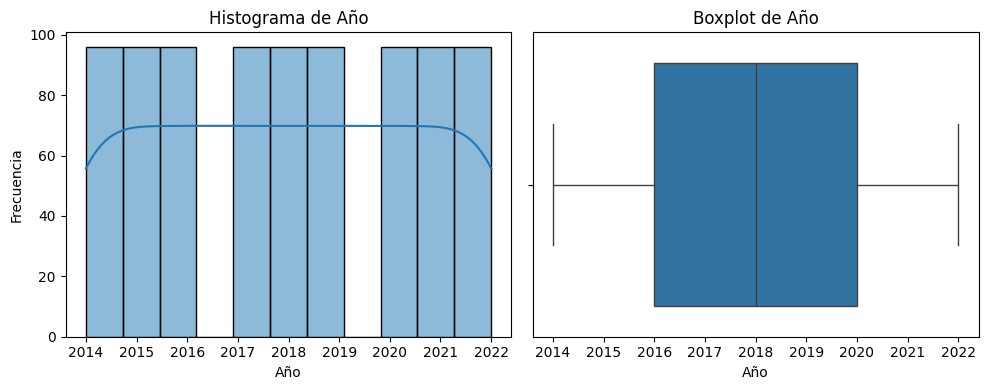

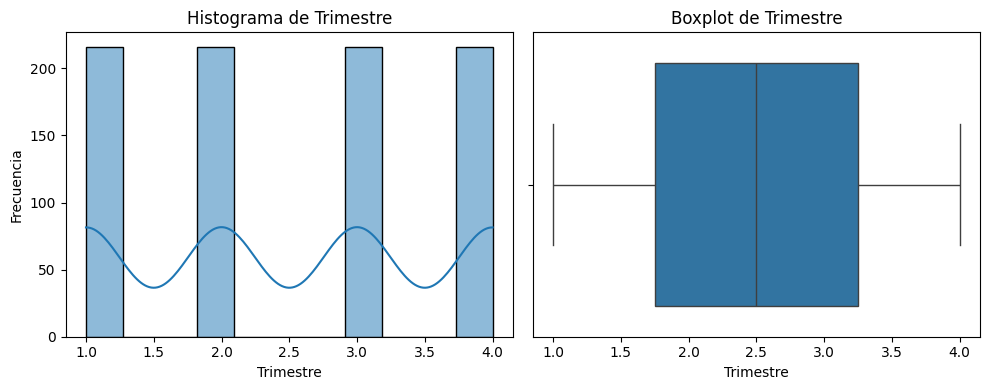

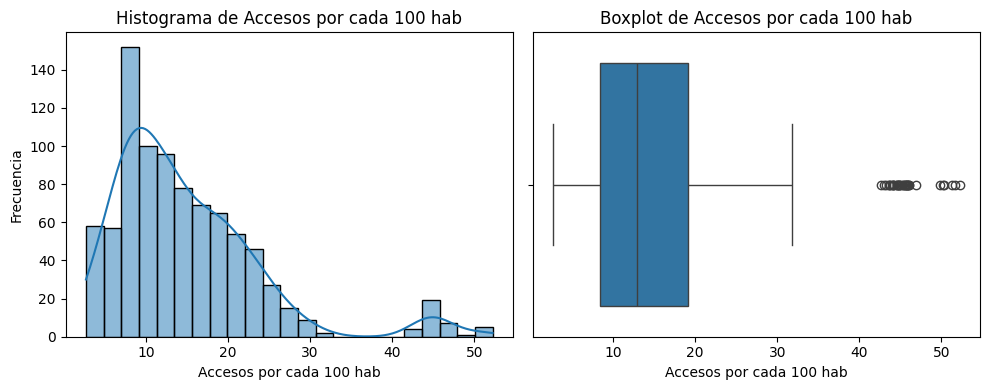

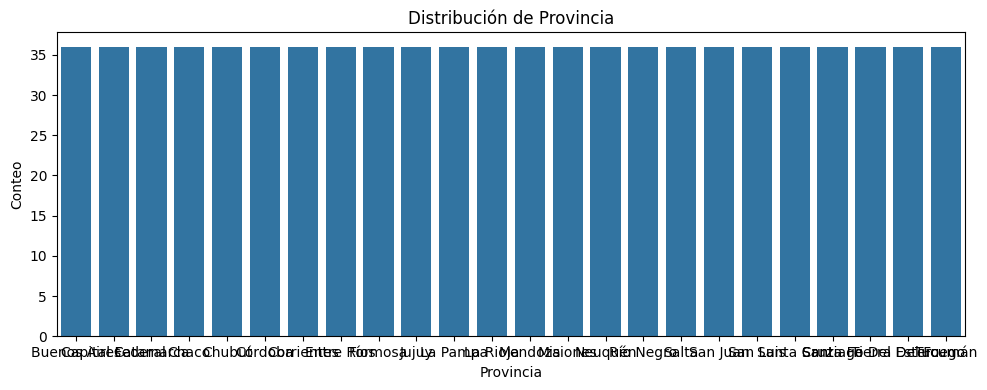

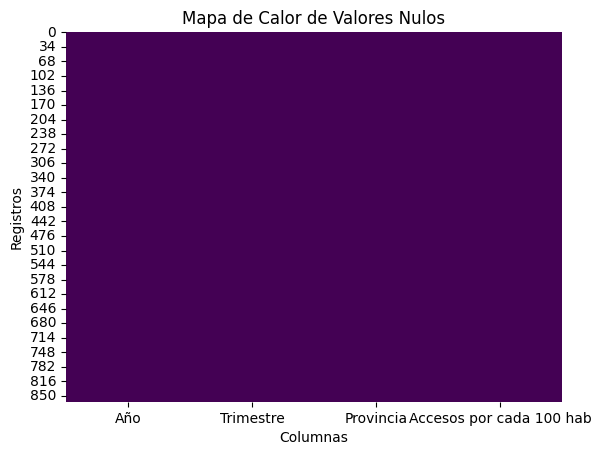

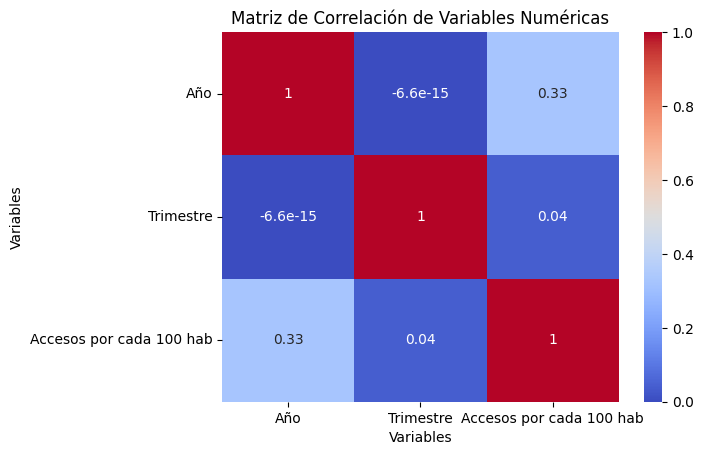

##################################################


In [21]:
informacion_dataframe('Penetración de Internet', df_penetracion_internet, visualizar=True, muestras=None, interactividad=True)


Al analizar el conjunto de datos de Penetración de Internet, hemos descubierto que no hay valores nulos y que no existen filas duplicadas, lo cual es excelente, ya que nos permite proceder con el análisis sin tener que realizar limpieza adicional. La presencia de 24 provincias únicas sugiere que tenemos una cobertura completa a nivel nacional en el conjunto de datos. Es notable que la provincia con mayor frecuencia en el conjunto de datos es Buenos Aires, lo que podría reflejar su importancia como centro urbano.

La distribución de los 'Accesos por cada 100 habitantes' muestra una variabilidad considerable, con un promedio de alrededor de 14.8 y una desviación estándar de aproximadamente 9.02, indicando que la penetración de internet varía significativamente entre las provincias. Los histogramas y boxplots revelan una distribución sesgada hacia la izquierda, con un rango que va de un mínimo de aproximadamente 2.68 a un máximo de 52.24. La presencia de valores atípicos por encima del límite superior indica que algunas provincias tienen una penetración de internet significativamente más alta que la mayoría.

La matriz de correlación nos muestra una relación positiva moderada (0.33) entre el 'Año' y los 'Accesos por cada 100 habitantes', sugiriendo un incremento en la penetración de internet a lo largo del tiempo. La correlación entre 'Trimestre' y 'Accesos por cada 100 habitantes' es mucho más débil (0.04), lo que implica que no hay una variación estacional fuerte en los datos.

El gráfico de barras interactivo de la distribución por provincia muestra un conteo uniforme para todas las provincias. Esto sugiere que los datos están equitativamente distribuidos en cuanto a la representación provincial, lo cual es ideal para un análisis comparativo.

#### Análisis Temporal con Gráficos de Línea
Para visualizar cómo la penetración de Internet ha cambiado año tras año y trimestre a trimestre:

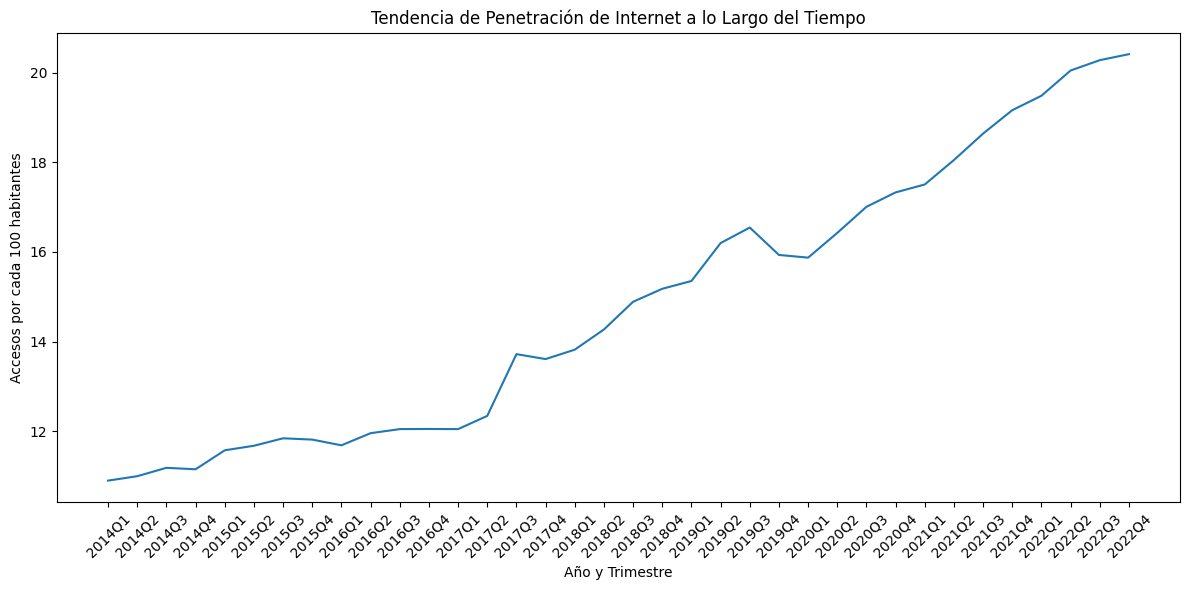

In [22]:
# Calcula la media de los 'Accesos por cada 100 habitantes' para cada grupo.
df_penetracion_internet['Año_Trimestre'] = df_penetracion_internet['Año'].astype(str) + 'Q' + df_penetracion_internet['Trimestre'].astype(str)
tendencia_anual = df_penetracion_internet.groupby('Año_Trimestre')['Accesos por cada 100 hab'].mean().reset_index()

# Crea un gráfico de líneas para mostrar la tendencia a lo largo del tiempo.
plt.figure(figsize=(12, 6))
sns.lineplot(data=tendencia_anual, x='Año_Trimestre', y='Accesos por cada 100 hab')
plt.title('Tendencia de Penetración de Internet a lo Largo del Tiempo')
plt.xlabel('Año y Trimestre')
plt.ylabel('Accesos por cada 100 habitantes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
tendencia_anual

Año_Trimestre  Accesos por cada 100 hab
0         2014Q1                 10.898731
1         2014Q2                 10.997066
2         2014Q3                 11.183974
3         2014Q4                 11.151011
4         2015Q1                 11.574764
5         2015Q2                 11.676198
6         2015Q3                 11.842587
7         2015Q4                 11.813529
8         2016Q1                 11.686046
9         2016Q2                 11.956545
10        2016Q3                 12.047460
11        2016Q4                 12.050664
12        2017Q1                 12.047223
13        2017Q2                 12.342974
14        2017Q3                 13.719669
15        2017Q4                 13.609577
16        2018Q1                 13.819501
17        2018Q2                 14.270190
18        2018Q3                 14.887830
19        2018Q4                 15.177253
20        2019Q1                 15.351482
21        2019Q2                 16.197250
22        2019Q3                 16.544147
23        2019Q4                 15.932594
24        2020Q1                 15.872215
25        2020Q2                 16.424323
26        2020Q3                 17.006347
27        2020Q4                 17.327362
28        2021Q1                 17.504511
29        2021Q2                 18.049848
30        2021Q3                 18.639783
31        2021Q4                 19.161457
32        2022Q1                 19.483505
33        2022Q2                 20.046800
34        2022Q3                 20.277083
35        2022Q4                 20.411250


Los datos presentados muestran un aumento sostenido y constante de los accesos a internet por cada 100 habitantes desde el primer trimestre de 2014 hasta el último trimestre de 2022. Este aumento puede ser indicativo de una mejora en la infraestructura de telecomunicaciones, una adopción tecnológica más amplia y una creciente digitalización en la región analizada.

Algunos puntos clave del análisis de los datos son:

- Tendencia General Ascendente: Existe una clara tendencia ascendente en la penetración de Internet, lo que sugiere un crecimiento constante en el número de accesos por cada 100 habitantes. Esto podría estar impulsado por factores como la reducción de costos de la tecnología, mejoras en la infraestructura, y políticas gubernamentales favorables.

- Incremento Anual: Cada año muestra un incremento en la penetración comparado con el anterior. Este es un indicador positivo y puede reflejar el éxito de las iniciativas para aumentar el acceso a internet en la región.

- Variaciones Trimestrales: Aunque hay un aumento anual, hay variaciones dentro de cada año que podrían estar relacionadas con factores estacionales, ciclos económicos o políticas específicas implementadas en esos periodos.

- Impacto a Largo Plazo: La trayectoria muestra que, a largo plazo, la penetración de internet ha ido en aumento. Esto podría tener implicaciones significativas para el desarrollo económico y social, ya que el acceso a internet es un facilitador clave para la educación, el comercio y la información.

- Puntos de Inflexión: Hay un notable salto en la penetración entre los años 2016 y 2017, y luego otro entre 2019 y 2020, lo que podría indicar eventos o inversiones significativas que han tenido un impacto positivo en la accesibilidad a internet.

- Efectos de la Pandemia: El aumento continuo durante los años 2020 y 2021 podría estar relacionado con la pandemia de COVID-19, que ha acelerado la digitalización y el uso de internet debido a las restricciones de movimiento y la necesidad de trabajar y estudiar desde casa.

- Sostenibilidad del Crecimiento: Mantener este crecimiento podría requerir políticas sostenibles y adaptativas que aborden los desafíos emergentes y aprovechen las nuevas tecnologías para seguir expandiendo el acceso a internet.

#### Comparación Provincial con Gráficos de Barras
Para comparar la penetración de Internet entre las provincias

C:\Users\Compumar\AppData\Local\Temp\ipykernel_16400\2593441480.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




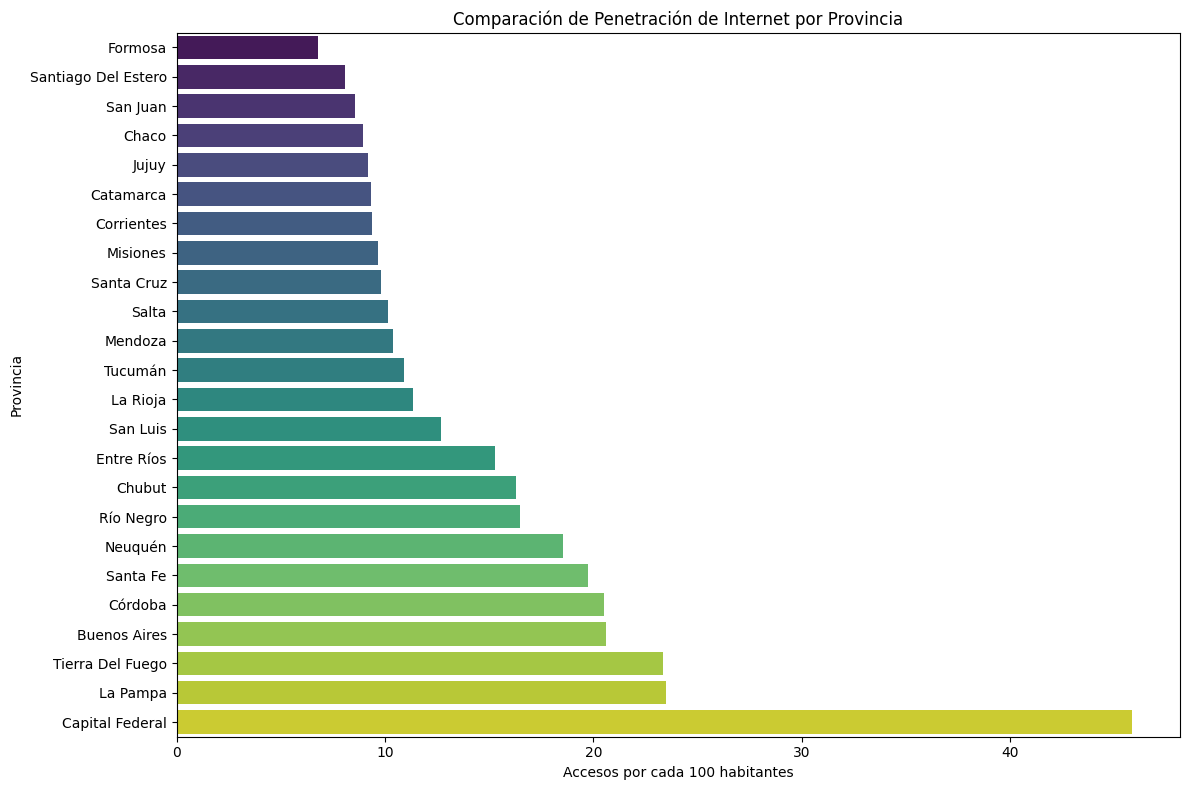

In [24]:
# Agrupa los datos por provincia y calcula la media de 'Accesos por cada 100 habitantes' para cada una
penetracion_provincial = df_penetracion_internet.groupby('Provincia')['Accesos por cada 100 hab'].mean().sort_values().reset_index()

#Crea un gráfico de barras para comparar las provincias.
plt.figure(figsize=(12, 8))
sns.barplot(data=penetracion_provincial, y='Provincia', x='Accesos por cada 100 hab', palette='viridis')
plt.title('Comparación de Penetración de Internet por Provincia')
plt.xlabel('Accesos por cada 100 habitantes')
plt.ylabel('Provincia')
plt.tight_layout()
plt.show()

In [25]:
penetracion_provincial

Provincia  Accesos por cada 100 hab
0               Formosa                  6.763641
1   Santiago Del Estero                  8.086490
2              San Juan                  8.560443
3                 Chaco                  8.943228
4                 Jujuy                  9.182760
5             Catamarca                  9.342567
6            Corrientes                  9.370685
7              Misiones                  9.668708
8            Santa Cruz                  9.792358
9                 Salta                 10.140681
10              Mendoza                 10.395216
11              Tucumán                 10.925153
12             La Rioja                 11.328203
13             San Luis                 12.687574
14           Entre Ríos                 15.292715
15               Chubut                 16.273044
16            Río Negro                 16.468452
17              Neuquén                 18.556712
18             Santa Fe                 19.753273
19              Córdoba                 20.501610
20         Buenos Aires                 20.624865
21     Tierra Del Fuego                 23.340801
22             La Pampa                 23.477192
23      Capital Federal                 45.845462

El análisis de la penetración de internet por provincia sugiere una variabilidad significativa en el acceso a internet en diferentes regiones. Aquí hay algunos puntos clave a considerar:

1. **Disparidad Regional**: Hay una gran disparidad en la penetración de internet entre las provincias, con Capital Federal liderando con casi un 46% de acceso y Formosa en el extremo inferior con aproximadamente un 6.76%. Esto podría reflejar diferencias en el desarrollo de infraestructura, el nivel de urbanización, y las políticas locales.

2. **Centros Urbanos vs. Regiones Rurales**: La alta penetración en Capital Federal puede atribuirse a su condición de centro urbano y económico, donde la infraestructura y los servicios tienden a ser más accesibles. Las provincias con menor penetración pueden ser más rurales o tener terrenos más desafiantes para la instalación de infraestructura de telecomunicaciones.

3. **Desarrollo Económico**: Las provincias con mayor penetración de internet, como Córdoba, Buenos Aires y Santa Fe, son también provincias con un mayor desarrollo económico, sugiriendo una correlación entre la riqueza económica y el acceso a servicios de internet.

4. **Inversión en Infraestructura**: La penetración puede ser indicativa del nivel de inversión en infraestructura digital en cada provincia. Es probable que las provincias con mayor acceso hayan tenido inversiones significativas en tecnología y conectividad.

5. **Factores Socioeconómicos**: Factores como la educación, el ingreso per cápita y la demanda de servicios digitales pueden influir en la penetración de internet. Las provincias con menores valores podrían tener desafíos en estos aspectos.

6. **Potencial de Crecimiento**: Las provincias con menor penetración presentan oportunidades significativas de crecimiento y desarrollo. Podría ser valioso para los responsables de la formulación de políticas y las empresas de telecomunicaciones centrarse en estas áreas para mejorar la conectividad.

7. **Calidad de la Conexión**: Además de la penetración, sería importante analizar la calidad y velocidad de la conexión disponible, ya que esto también afecta la utilidad y el impacto del acceso a internet.

Para profundizar el análisis, sería útil realizar un desglose temporal para ver cómo ha cambiado la penetración con el tiempo en cada provincia y correlacionarlo con cambios en políticas gubernamentales, programas de inversión y otros eventos significativos. Además, analizar la penetración junto con datos demográficos y económicos permitiría una comprensión más detallada de las dinámicas subyacentes que impulsan estas cifras.

#### Desglose por Trimestre
Para examinar patrones estacionales:



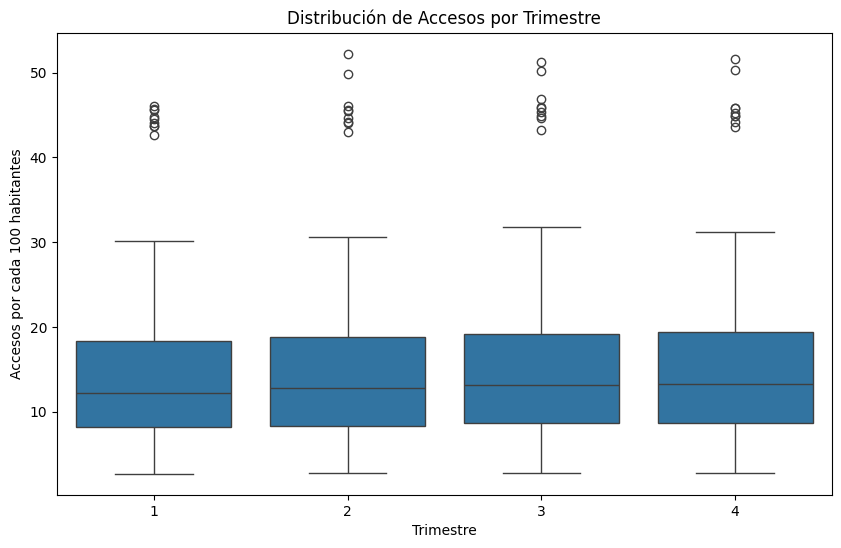

In [26]:
#Crea gráficos de cajas para cada trimestre y compara las distribuciones.

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_penetracion_internet, x='Trimestre', y='Accesos por cada 100 hab')
plt.title('Distribución de Accesos por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Accesos por cada 100 habitantes')
plt.show()


In [27]:
# Agrupamos por 'Trimestre' y obtenemos las estadísticas descriptivas para cada grupo
descripcion_por_trimestre = df_penetracion_internet.groupby('Trimestre')['Accesos por cada 100 hab'].describe()

# Imprimimos la tabla resultante
print(descripcion_por_trimestre)


           count       mean       std       min       25%        50%  \
Trimestre                                                              
1          216.0  14.248664  8.791559  2.684669  8.227373  12.174560   
2          216.0  14.662355  9.088664  2.723000  8.357069  12.779472   
3          216.0  15.127653  9.117518  2.747243  8.698282  13.106351   
4          216.0  15.181633  9.115610  2.741027  8.706430  13.297694   

                 75%        max  
Trimestre                        
1          18.351730  46.014348  
2          18.849357  52.236739  
3          19.200222  51.244450  
4          19.354126  51.616721  


Se pueden hacer las siguientes observaciones:

1. **Número de Observaciones (count)**: Cada trimestre tiene 216 observaciones, lo que indica que los datos están distribuidos de manera uniforme a través de los trimestres. Esto es bueno para hacer comparaciones porque significa que cada trimestre está representado equitativamente.

2. **Promedio (mean)**: El promedio de accesos por cada 100 habitantes incrementa ligeramente de un trimestre a otro, comenzando con 14.25 en el primer trimestre y subiendo a 15.18 en el cuarto. Este aumento sugiere una tendencia general de crecimiento en la penetración de Internet a lo largo del año.

3. **Desviación Estándar (std)**: Las desviaciones estándar son altas en todos los trimestres y muy cercanas entre sí, lo que indica una variabilidad significativa en los accesos por cada 100 habitantes dentro de cada trimestre.

4. **Mínimo (min)**: Los valores mínimos son muy similares a través de los trimestres, ligeramente incrementando, lo que sugiere que las áreas con menor penetración de Internet están mejorando muy gradualmente o se mantienen estables.

5. **Percentiles (25%, 50%, 75%)**:
   - El 25% de los datos (primer cuartil) aumenta levemente cada trimestre, lo que podría indicar que la 'base' de la penetración de Internet está mejorando.
   - La mediana (50%) también aumenta trimestre a trimestre, lo que confirma la tendencia al alza en la penetración de Internet.
   - El tercer cuartil (75%) muestra un aumento, lo que sugiere que la 'parte superior' de los datos también está viendo un crecimiento.

6. **Máximo (max)**: Hay un notable incremento en los valores máximos desde el primer al segundo trimestre, y se mantienen altos para el tercer y cuarto trimestre. Esto podría ser indicativo de que algunas provincias o regiones tienen aumentos significativos en la penetración durante ciertas épocas del año, o que hay casos aislados de crecimiento muy alto.

En resumen, estos datos sugieren que hay un crecimiento constante en la penetración de Internet a lo largo del año y que la variabilidad es bastante consistente a través de los trimestres. Sin embargo, también indican que podría haber diferencias significativas entre regiones o provincias, como lo sugieren los valores máximos que se mantienen altos y los incrementos en los diferentes cuartiles.

#### Análisis de Outliers
Utilizando el método del rango intercuartílico (IQR). Este método es comúnmente usado ya que es resistente a los extremos y se basa en medidas de posición central y dispersión.

Pasos a seguir: 

1. Calcula el primer cuartil (Q1) y el tercer cuartil (Q3) de la variable de interés.
2. Calcula el IQR como la diferencia entre Q3 y Q1.
3. Determina los límites inferior y superior para identificar outliers. Los outliers son aquellos puntos de datos que caen por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR.




In [28]:
Q1 = df_penetracion_internet['Accesos por cada 100 hab'].quantile(0.25)
Q3 = df_penetracion_internet['Accesos por cada 100 hab'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df_penetracion_internet[(df_penetracion_internet['Accesos por cada 100 hab'] < limite_inferior) | (df_penetracion_internet['Accesos por cada 100 hab'] > limite_superior)]

# Muestra los outliers
print(outliers)


      Año  Trimestre        Provincia  Accesos por cada 100 hab Año_Trimestre
1    2022          4  Capital Federal                 50.350000        2022Q4
25   2022          3  Capital Federal                 50.220000        2022Q3
49   2022          2  Capital Federal                 49.873561        2022Q2
73   2022          1  Capital Federal                 46.014348        2022Q1
97   2021          4  Capital Federal                 45.848511        2021Q4
121  2021          3  Capital Federal                 45.900383        2021Q3
145  2021          2  Capital Federal                 45.487190        2021Q2
169  2021          1  Capital Federal                 44.826990        2021Q1
193  2020          4  Capital Federal                 44.833968        2020Q4
217  2020          3  Capital Federal                 44.622743        2020Q3
241  2020          2  Capital Federal                 44.151827        2020Q2
265  2020          1  Capital Federal                 44.024082 

Los outliers identificados son todos de Capital Federal, lo que sugiere una alta penetración de internet en comparación con otras provincias del país. Este fenómeno podría deberse a varios factores:

1. **Desarrollo Urbano:** Capital Federal, al ser un área urbana densamente poblada y centro de negocios, es probable que tenga mejor infraestructura de telecomunicaciones y mayor inversión en tecnologías de la información.

2. **Acceso y Asequibilidad:** La concentración de servicios y la competencia entre proveedores pueden hacer que el acceso a Internet sea más asequible y esté más ampliamente disponible.

3. **Demografía y Socioeconomía:** Las áreas urbanas a menudo tienen una población con mayor nivel educativo y mayores ingresos, lo que se correlaciona con una mayor adopción de tecnología.

4. **Políticas y Regulaciones:** Puede haber políticas específicas o incentivos en la Capital Federal que fomenten la expansión del acceso a Internet.

5. **Estabilidad y Continuidad:** La presencia constante de outliers a lo largo del tiempo indica que este no es un fenómeno aislado sino más bien una tendencia estable y continua.

Sería interesante comparar estos datos con indicadores socioeconómicos como el PBI per cápita, el nivel de educación y la disponibilidad de infraestructura de TI para obtener una comprensión más completa de las razones detrás de estos valores atípicos.

#### Gráfico de lineas por provincia

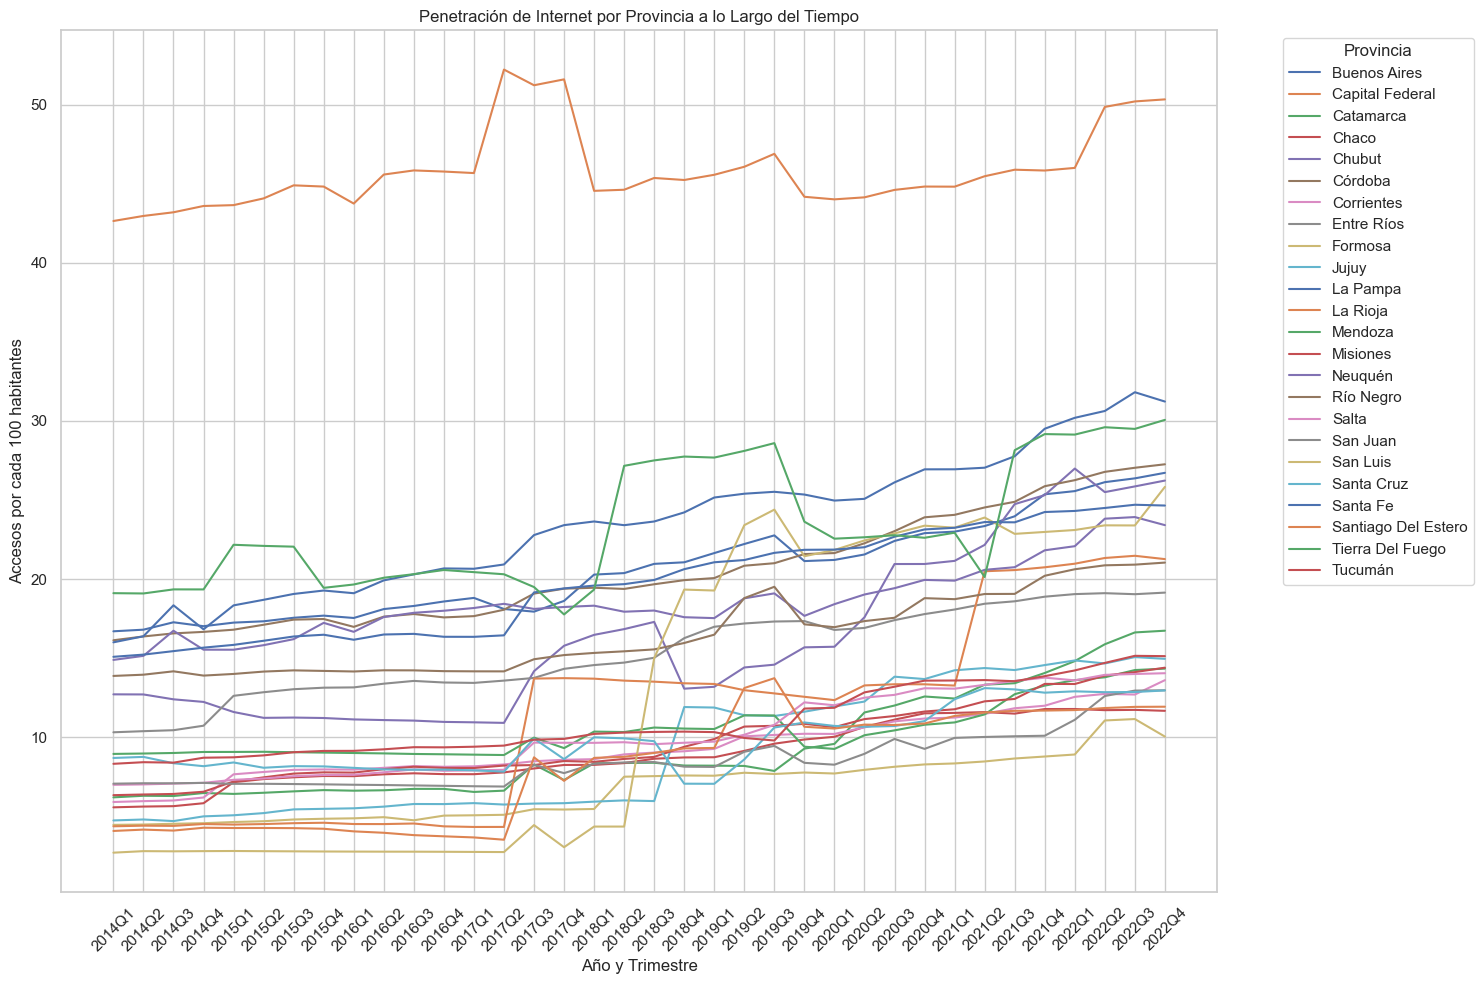

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para que todas las líneas de las provincias se incluyan en la leyenda.
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))

# Generar un gráfico de líneas para cada provincia.
for provincia in df_penetracion_internet['Provincia'].unique():
    provincia_data = df_penetracion_internet[df_penetracion_internet['Provincia'] == provincia]
    sns.lineplot(data=provincia_data, x='Año_Trimestre', y='Accesos por cada 100 hab', label=provincia)

# Invertir el eje X.
plt.gca().invert_xaxis()

# Mejorar la visualización.
plt.xticks(rotation=45)
plt.xlabel('Año y Trimestre')
plt.ylabel('Accesos por cada 100 habitantes')
plt.title('Penetración de Internet por Provincia a lo Largo del Tiempo')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [30]:
# Crear la tabla de resumen.
tabla_resumen = df_penetracion_internet.pivot_table(index='Provincia', 
                                                    columns='Año_Trimestre', 
                                                    values='Accesos por cada 100 hab', 
                                                    aggfunc='mean')

# Imprimir la tabla de resumen.
print(tabla_resumen)


Año_Trimestre           2014Q1     2014Q2     2014Q3     2014Q4     2015Q1  \
Provincia                                                                    
Buenos Aires         16.692346  16.794925  17.262998  17.014763  17.241393   
Capital Federal      42.655072  42.974777  43.206400  43.604621  43.658725   
Catamarca             6.184615   6.284355   6.269890   6.459255   6.403017   
Chaco                 5.553671   5.602128   5.627757   5.813682   7.143089   
Chubut               12.703590  12.696289  12.388234  12.223556  11.585799   
Corrientes            5.891708   5.945267   5.986283   6.174655   7.642569   
Córdoba              16.125183  16.365408  16.560137  16.655707  16.793622   
Entre Ríos           10.302247  10.372072  10.433826  10.718328  12.609336   
Formosa               4.444468   4.464870   4.512925   4.549163   4.623849   
Jujuy                 4.724303   4.784095   4.683394   4.982004   5.050880   
La Pampa             15.994062  16.379049  18.337534  16.816525 

El análisis del gráfico y la tabla de resumen revela varios puntos clave:

1. **Crecimiento Sostenido**: Casi todas las provincias muestran un aumento constante en la penetración de internet con el tiempo. Esto indica una tendencia general positiva en la expansión del acceso a internet a nivel nacional.

2. **Disparidades Regionales**: Existe una disparidad significativa entre provincias como Capital Federal, que tiene valores mucho más altos de penetración de internet, y otras como San Luis y Formosa con valores considerablemente más bajos. Esto podría indicar diferencias en la infraestructura de telecomunicaciones, la economía o la demografía entre provincias.

3. **Desarrollo acelerado en ciertas áreas**: Algunas provincias, como La Rioja y Formosa, muestran un crecimiento acelerado en los últimos trimestres. Esto podría estar relacionado con iniciativas específicas de desarrollo o inversiones en infraestructura digital.

4. **Capital Federal como outlier**: La Capital Federal se destaca claramente como un outlier con niveles de acceso significativamente más altos que el resto de las provincias, lo que indica que es un centro urbano muy conectado, posiblemente debido a la concentración de servicios y la densidad de población.

5. **Importancia de políticas públicas**: Las tendencias de crecimiento sugieren que las políticas públicas y las inversiones en infraestructura de telecomunicaciones pueden estar teniendo un efecto positivo, pero el enfoque debe ser equitativo para abordar las brechas regionales.

6. **Necesidad de más análisis**: Sería útil realizar un análisis más profundo para entender las causas de las disparidades regionales y los picos de crecimiento. Esto podría incluir el examen de factores socioeconómicos, la calidad de la infraestructura de internet y la accesibilidad de los servicios.

### Accesos a Internet Nacional
  Análisis de la transición de banda angosta a banda ancha con gráficos de barras apiladas que muestren la proporción trimestral.

Analizando: Accesos a Internet Nacional
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               36 non-null     object 
 1   Trimestre         36 non-null     object 
 2   Banda ancha fija  36 non-null     float64
 3   Dial up           36 non-null     float64
 4   Total             36 non-null     float64
 5   Periodo           36 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.8+ KB
None

Estadísticas Descriptivas:
         Año Trimestre  Banda ancha fija    Dial up      Total       Periodo
count     36        36         36.000000  36.000000  36.000000            36
unique     9         4               NaN        NaN        NaN            36
top     2022         4               NaN        NaN        NaN  Oct-Dic 2022
freq       4         9               NaN        NaN   

Año Trimestre  Banda ancha fija  Dial up  Total        Periodo
0   2022         4              11.0     12.0   11.0   Oct-Dic 2022
1   2022         3              11.0     12.0   11.0  Jul-Sept 2022
2   2022         2              11.0     12.0   11.0   Abr-Jun 2022
3   2022         1              11.0     13.0   11.0   Ene-Mar 2022
4   2021         4              10.0     13.0   10.0   Oct-Dic 2021
31  2015         1               7.0     38.0    7.0   Ene-Mar 2015
32  2014         4               7.0     39.0    7.0   Oct-Dic 2014
33  2014         3               7.0     36.0    7.0  Jul-Sept 2014
34  2014         2               6.0     36.0    6.0   Abr-Jun 2014
35  2014         1               6.0     36.0    6.0   Ene-Mar 2014


Valores nulos por columna:
                  Cantidad  Porcentaje
Año                      0         0.0
Trimestre                0         0.0
Banda ancha fija         0         0.0
Dial up                  0         0.0
Total                    0         0.0
Periodo                  0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Año': 9
Valor más común en 'Año': 2014

Número de valores únicos en 'Trimestre': 4
Valor más común en 'Trimestre': 1

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014


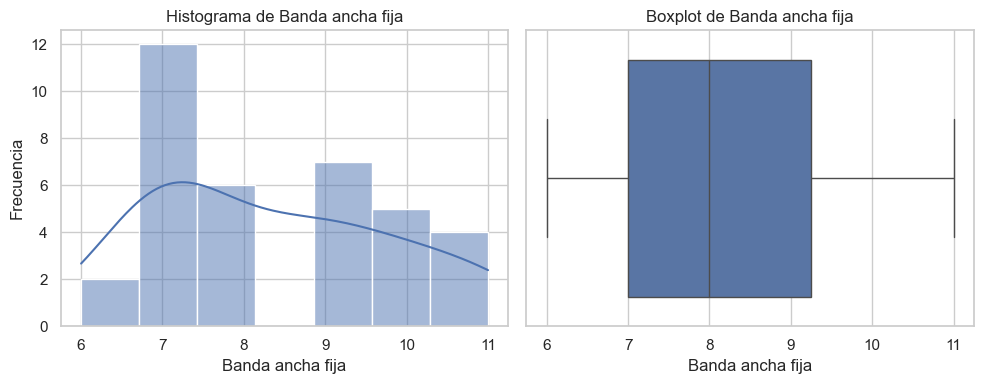

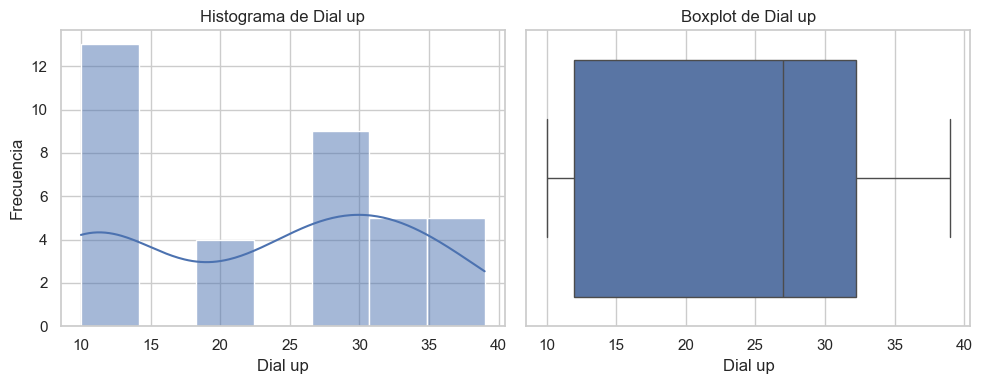

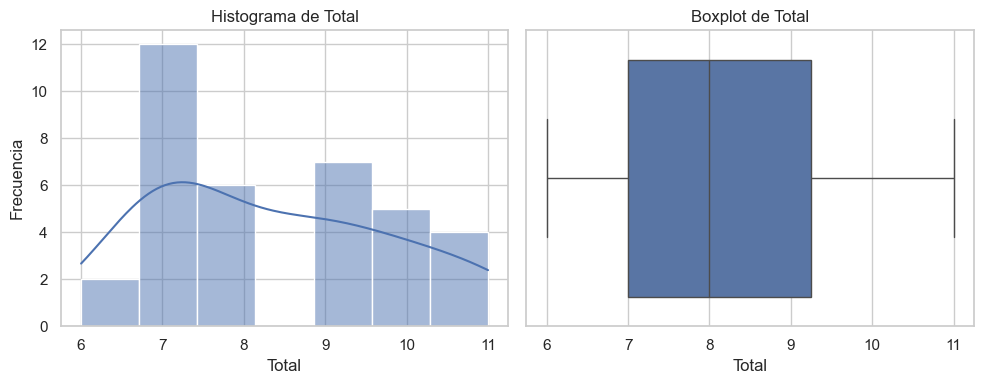

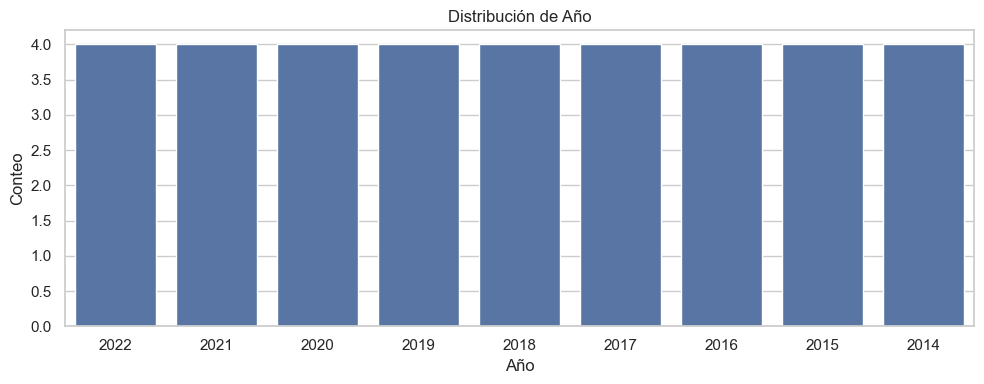

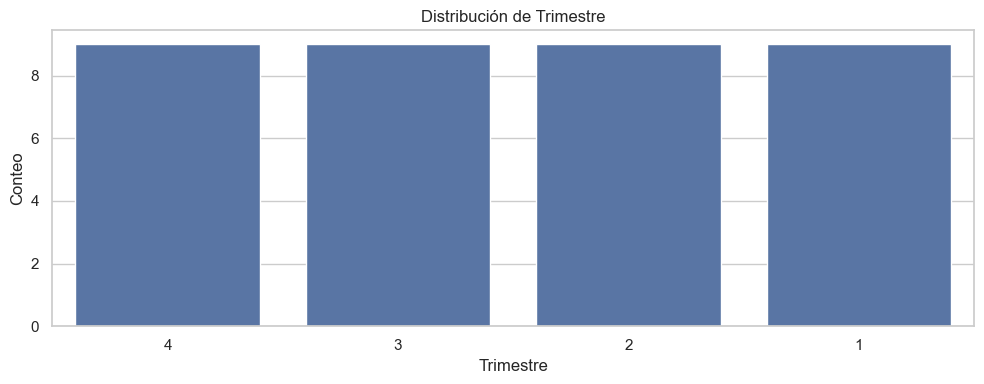

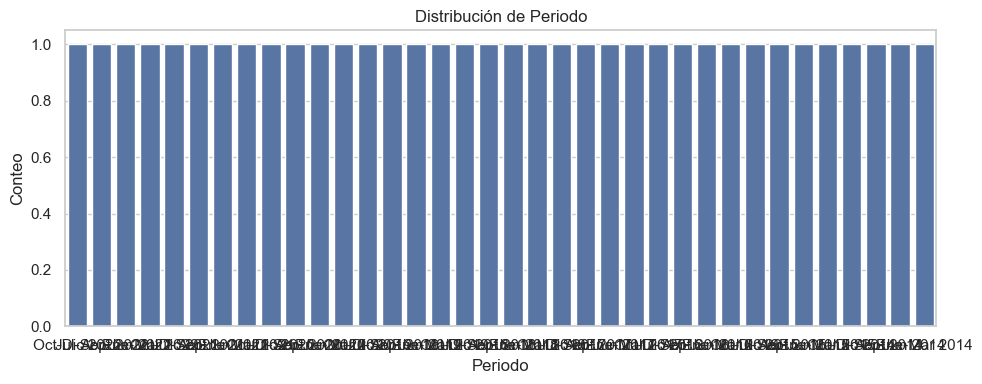

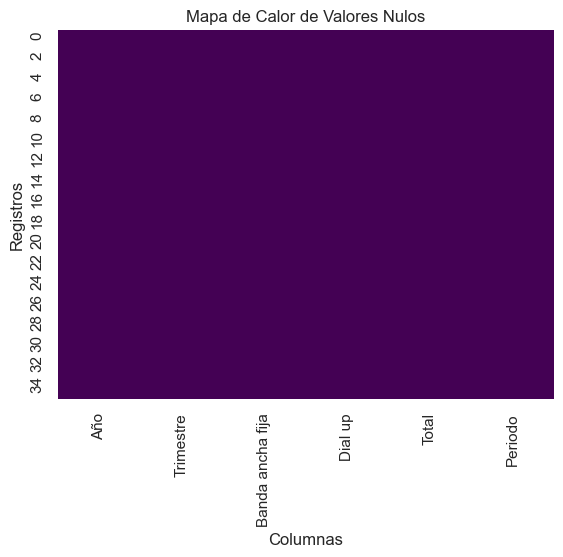

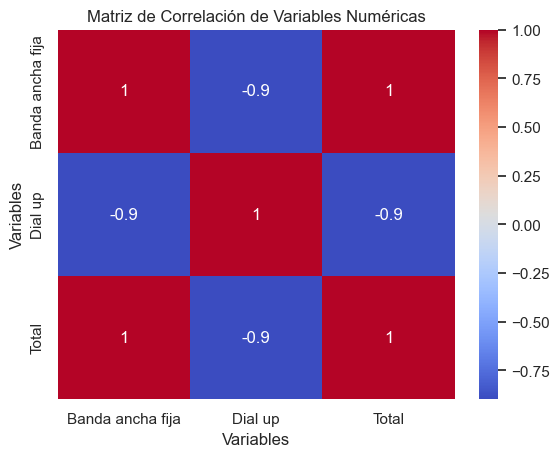

##################################################


In [31]:

informacion_dataframe('Accesos a Internet Nacional', df_accesos_internet_nacional, visualizar=True, muestras=None, interactividad=True)



Algunas observaciones clave basadas en el resumen estadístico y la estructura del DataFrame:

1. **Consistencia de Datos**: No hay valores nulos y no hay filas duplicadas.

2. **Variedad Temporal**: Los datos cubren 9 años y todos los trimestres dentro de esos años, lo que permite un análisis temporal detallado.

3. **Distribución de la Banda Ancha Fija**: La mediana de accesos de banda ancha fija es de 8 (por cada 100 habitantes, asumo), y la mayoría de los valores se distribuyen entre 7 y 9.5, con algunos trimestres alcanzando un máximo de 11. Esto sugiere un crecimiento relativamente constante en la penetración de la banda ancha fija a lo largo del tiempo.

4. **Distribución de Dial up**: Existe una fuerte correlación negativa (-0.9) entre los accesos de banda ancha fija y Dial up, lo que es esperado ya que la tecnología Dial up ha quedado obsoleta frente a la banda ancha. La mediana es 27, lo que indica que, mientras la banda ancha fija crecía, los accesos por Dial up disminuyeron, como se ve en la reducción a 10 en los últimos trimestres.

5. **Tendencias y Correlaciones**: La correlación de -0.9 entre banda ancha y Dial up sugiere una relación inversa, lo que significa que a medida que aumentan los accesos de banda ancha fija, los de Dial up disminuyen. La correlación perfecta (1) entre banda ancha fija y el Total indica que probablemente el Total representa la suma de banda ancha fija y Dial up.

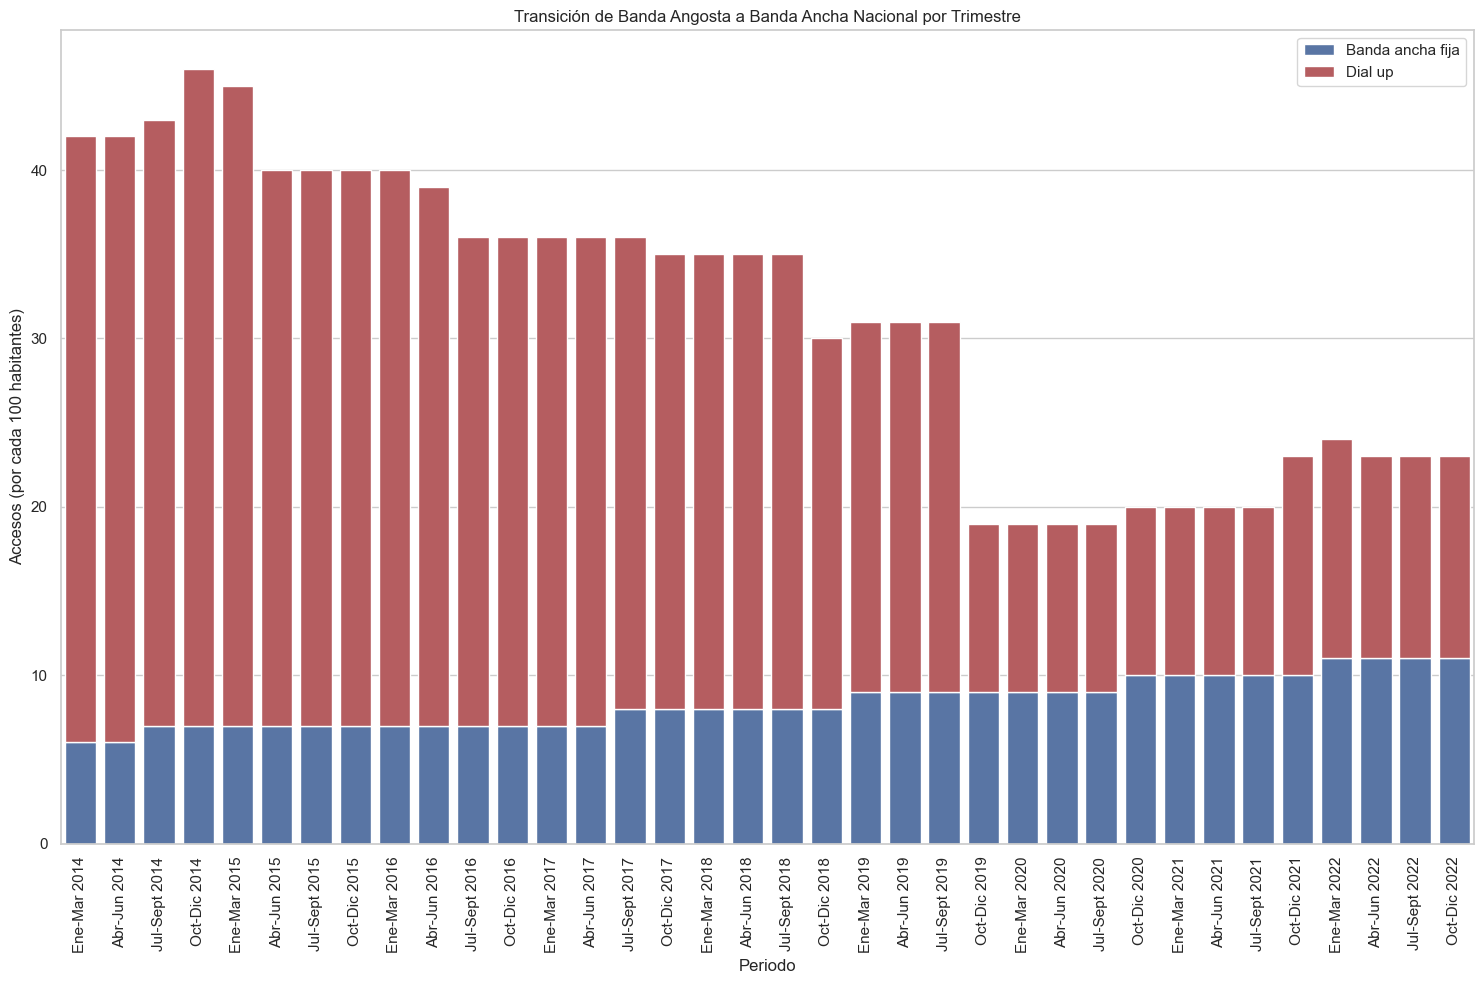

In [32]:
# Configuración del estilo de Seaborn
sns.set(style="whitegrid")

# Crea una figura y un eje para el plot
plt.figure(figsize=(15, 10))

# Primero, graficamos la banda ancha fija
bar_banda_ancha = sns.barplot(data=df_accesos_internet_nacional, x='Periodo', y='Banda ancha fija', color='b', label='Banda ancha fija')

# Luego, graficamos el dial up encima de la banda ancha fija
bar_dial_up = sns.barplot(data=df_accesos_internet_nacional, x='Periodo', y='Dial up', color='r', bottom=df_accesos_internet_nacional['Banda ancha fija'], label='Dial up')

# Mejora en la visualización
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para que sean legibles

# Invertir el eje x
plt.gca().invert_xaxis()

# Configura las etiquetas y títulos
plt.xlabel('Periodo')
plt.ylabel('Accesos (por cada 100 habitantes)')
plt.title('Transición de Banda Angosta a Banda Ancha Nacional por Trimestre')

# Muestra la leyenda
plt.legend()

# Ajusta la disposición para que todo encaje y muestre el gráfico
plt.tight_layout()
plt.show()


In [33]:
# Creamos una tabla pivote para reorganizar los datos
tabla_pivote = df_accesos_internet_nacional.pivot_table(index=['Año', 'Trimestre'], 
                                                         values=['Banda ancha fija', 'Dial up', 'Total'],
                                                         aggfunc='sum')

# Mostramos la tabla pivote
print(tabla_pivote)


                Banda ancha fija  Dial up  Total
Año  Trimestre                                  
2014 1                       6.0     36.0    6.0
     2                       6.0     36.0    6.0
     3                       7.0     36.0    7.0
     4                       7.0     39.0    7.0
2015 1                       7.0     38.0    7.0
     2                       7.0     33.0    7.0
     3                       7.0     33.0    7.0
     4                       7.0     33.0    7.0
2016 1                       7.0     33.0    7.0
     2                       7.0     32.0    7.0
     3                       7.0     29.0    7.0
     4                       7.0     29.0    7.0
2017 1                       7.0     29.0    7.0
     2                       7.0     29.0    7.0
     3                       8.0     28.0    8.0
     4                       8.0     27.0    8.0
2018 1                       8.0     27.0    8.0
     2                       8.0     27.0    8.0
     3              

In [34]:
# Configura 'Periodo' como índice para reflejar el eje x del gráfico
tabla_reflejo_grafico = df_accesos_internet_nacional.set_index('Periodo')[['Banda ancha fija', 'Dial up']]

# La tabla ahora tiene 'Periodo' como índice y las columnas 'Banda ancha fija' y 'Dial up' como datos
# Mostramos la tabla
print(tabla_reflejo_grafico)


               Banda ancha fija  Dial up
Periodo                                 
Oct-Dic 2022               11.0     12.0
Jul-Sept 2022              11.0     12.0
Abr-Jun 2022               11.0     12.0
Ene-Mar 2022               11.0     13.0
Oct-Dic 2021               10.0     13.0
Jul-Sept 2021              10.0     10.0
Abr-Jun 2021               10.0     10.0
Ene-Mar 2021               10.0     10.0
Oct-Dic 2020               10.0     10.0
Jul-Sept 2020               9.0     10.0
Abr-Jun 2020                9.0     10.0
Ene-Mar 2020                9.0     10.0
Oct-Dic 2019                9.0     10.0
Jul-Sept 2019               9.0     22.0
Abr-Jun 2019                9.0     22.0
Ene-Mar 2019                9.0     22.0
Oct-Dic 2018                8.0     22.0
Jul-Sept 2018               8.0     27.0
Abr-Jun 2018                8.0     27.0
Ene-Mar 2018                8.0     27.0
Oct-Dic 2017                8.0     27.0
Jul-Sept 2017               8.0     28.0
Abr-Jun 2017    

Se observa una tendencia significativa en el cambio de dial up a banda ancha fija a lo largo del periodo de 2014 a 2022. Aquí hay un análisis centrado en los cambios notables y sus posibles causas:

**Aumento de Banda Ancha Fija:**

- **2014 a 2015**: El cambio no es muy significativo, lo que sugiere una adopción gradual de la banda ancha fija. Este periodo podría estar marcado por la mejora en la infraestructura de red que aún no había alcanzado una masa crítica.

- **2019**: Hay un salto notable en la adopción de la banda ancha fija, que pasa de 8 accesos por cada 100 habitantes a 9. Esto puede ser indicativo de una mejora en la infraestructura de telecomunicaciones o la introducción de políticas favorables.

- **2020 a 2022**: Se observa un aumento constante y sostenido en la banda ancha fija, alcanzando los 11 accesos por cada 100 habitantes. Este incremento podría deberse a la digitalización acelerada provocada por la pandemia de COVID-19, donde la demanda de servicios de internet de alta velocidad para trabajo y educación remota se disparó.

**Disminución de Dial Up:**

- **2018 a 2019**: La disminución más significativa en el uso de dial up ocurre entre estos años, cayendo de 22 a 10 accesos por cada 100 habitantes. Este cambio drástico podría estar relacionado con la obsolescencia tecnológica del dial up y la transición a tecnologías más modernas.

- **2019 en adelante**: El dial up se mantiene en un mínimo de 10 accesos por cada 100 habitantes, lo que puede indicar un piso para usuarios que se resisten al cambio o que no tienen otra opción debido a limitaciones geográficas o económicas.

**Posibles Causas y Factores Contribuyentes:**

- **Inversiones en Infraestructura**: La expansión de la infraestructura de banda ancha fija en áreas urbanas y rurales podría explicar el crecimiento sostenido.

- **Políticas Gubernamentales**: Las iniciativas y subsidios para promover la accesibilidad y asequibilidad de la banda ancha pueden haber estimulado el crecimiento.

- **Cambios en el Comportamiento del Consumidor**: La creciente preferencia por el streaming de video, el gaming en línea y el trabajo remoto requieren de una conexión de internet más rápida y fiable que la banda ancha fija puede proporcionar.

- **Disminución de Costos**: La reducción en los precios de los servicios de banda ancha fija debido a la competencia y la mejora de las tecnologías podría haber facilitado el acceso a una base de consumidores más amplia.

- **Eventos Globales**: La pandemia de COVID-19 es un claro catalizador del cambio, forzando a individuos y empresas a depender más del internet para sus actividades diarias.

### Penetración Trimestral en Hogares

In [35]:
# Primero reemplazamos las comas por puntos en las columnas relevantes
df_penetracion_trimestral_hogares['Accesos por cada 100 hogares'] = df_penetracion_trimestral_hogares['Accesos por cada 100 hogares'].str.replace(',', '.')
df_penetracion_trimestral_hogares['Accesos por cada 100 hab'] = df_penetracion_trimestral_hogares['Accesos por cada 100 hab'].str.replace(',', '.')

# Luego convertimos las columnas a tipo flotante
df_penetracion_trimestral_hogares['Accesos por cada 100 hogares'] = df_penetracion_trimestral_hogares['Accesos por cada 100 hogares'].astype(float)
df_penetracion_trimestral_hogares['Accesos por cada 100 hab'] = df_penetracion_trimestral_hogares['Accesos por cada 100 hab'].astype(float)

# Verificamos los cambios en los tipos de datos
print(df_penetracion_trimestral_hogares.dtypes)


Año                               int64
Trimestre                         int64
Accesos por cada 100 hogares    float64
Accesos por cada 100 hab        float64
Periodo                          object
dtype: object


Analizando: Penetración Trimestral en Hogares
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           36 non-null     int64  
 1   Trimestre                     36 non-null     int64  
 2   Accesos por cada 100 hogares  36 non-null     float64
 3   Accesos por cada 100 hab      36 non-null     float64
 4   Periodo                       36 non-null     object 
dtypes: float64(2), int64(2), object(1)
memory usage: 1.5+ KB
None

Estadísticas Descriptivas:
                Año  Trimestre  Accesos por cada 100 hogares  \
count     36.000000  36.000000                     36.000000   
unique          NaN        NaN                           NaN   
top             NaN        NaN                           NaN   
freq            NaN        NaN                       

Año  Trimestre  Accesos por cada 100 hogares  Accesos por cada 100 hab  \
0   2022          4                         77.21                     24.15   
1   2022          3                         76.64                     23.95   
2   2022          2                         75.97                     23.72   
3   2022          1                         73.88                     23.05   
4   2021          4                         73.18                     22.81   
31  2015          1                         51.36                     15.68   
32  2014          4                         50.50                     15.39   
33  2014          3                         50.67                     15.43   
34  2014          2                         49.86                     15.16   
35  2014          1                         49.55                     15.05   

          Periodo  
0    Oct-Dic 2022  
1   Jul-Sept 2022  
2    Abr-Jun 2022  
3    Ene-Mar 2022  
4    Oct-Dic 2021  
31   Ene-Mar 2015  
32   Oct-Dic 2014  
33  Jul-Sept 2014  
34   Abr-Jun 2014  
35   Ene-Mar 2014


Valores nulos por columna:
                              Cantidad  Porcentaje
Año                                  0         0.0
Trimestre                            0         0.0
Accesos por cada 100 hogares         0         0.0
Accesos por cada 100 hab             0         0.0
Periodo                              0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014


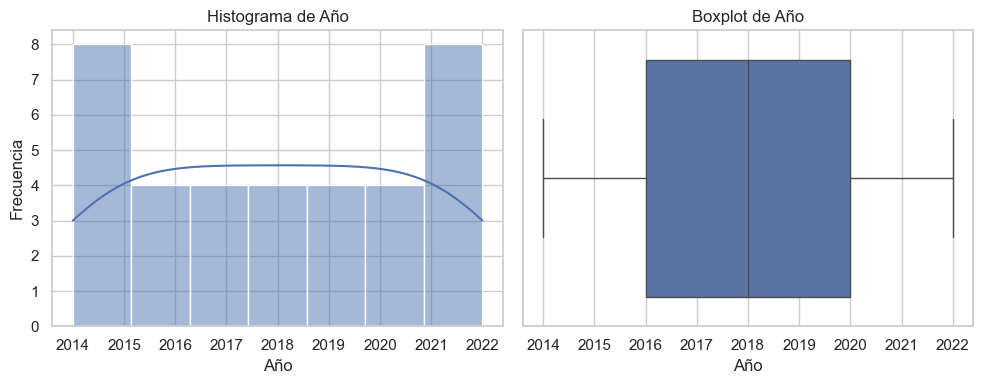

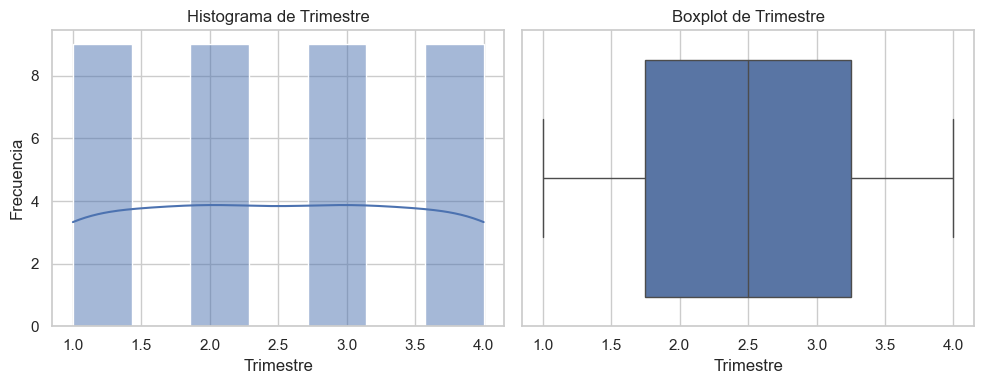

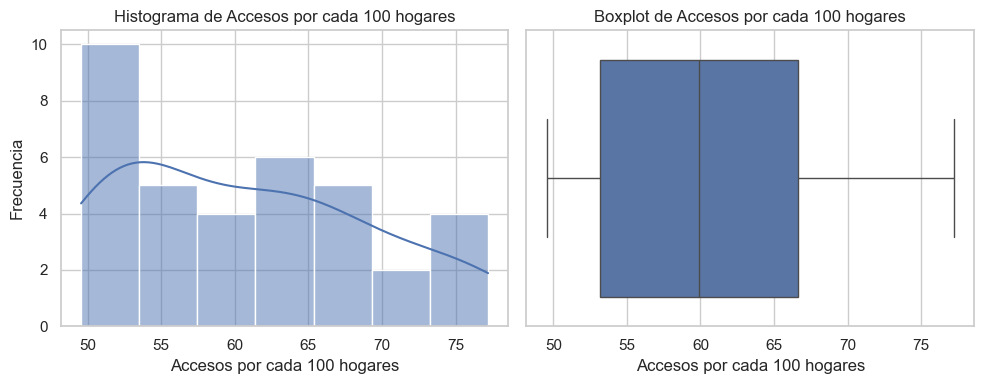

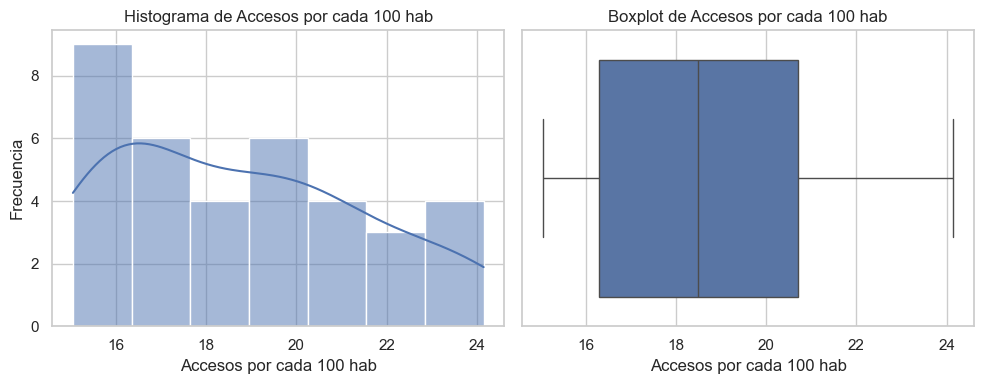

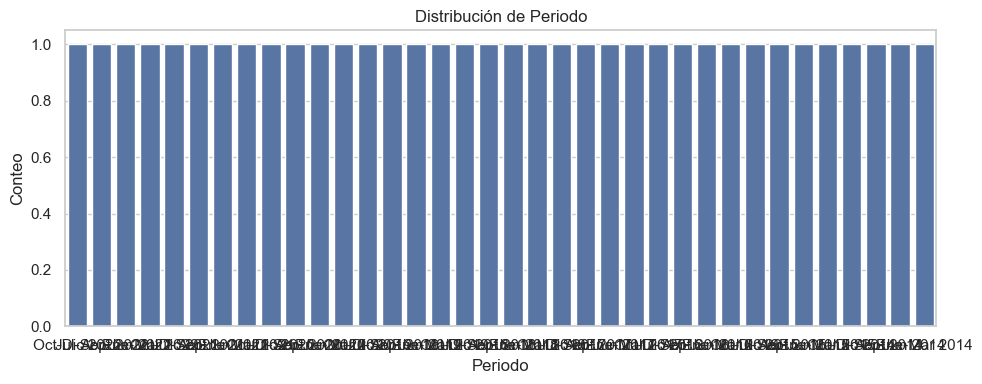

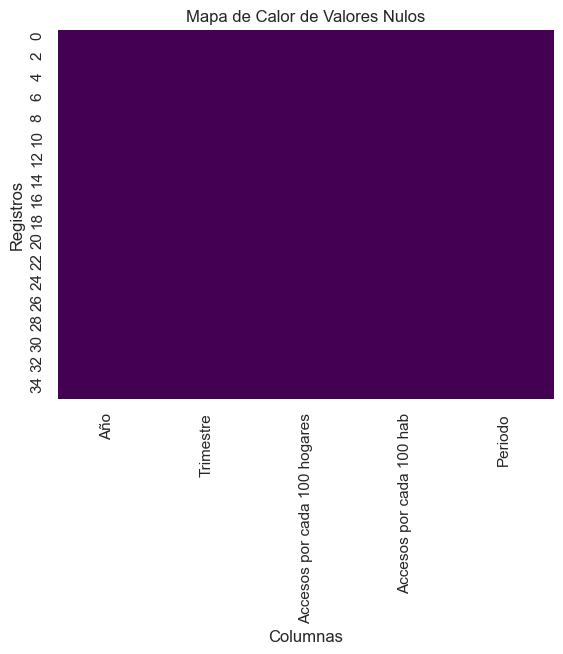

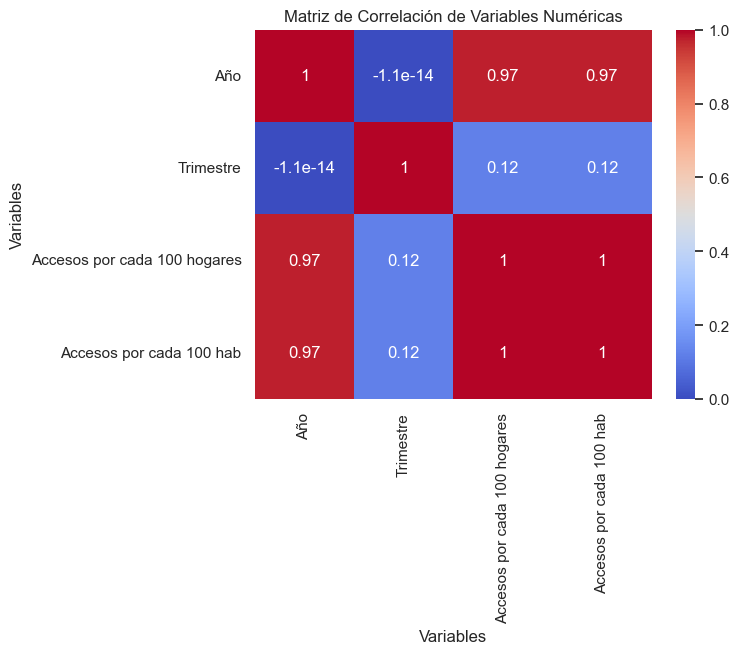

##################################################


In [36]:
informacion_dataframe('Penetración Trimestral en Hogares', df_penetracion_trimestral_hogares, visualizar=True, muestras=None, interactividad=True)

Insights útiles:

1. **Tendencia General**: Existe una fuerte tendencia positiva en la penetración de internet en hogares y por individuo desde 2014 hasta 2022. Esto se refleja en la alta correlación (0.97) entre el año y los accesos, indicando un crecimiento consistente a lo largo del tiempo.

2. **Distribución Temporal**: Los histogramas y boxplots sugieren una distribución equitativa de los datos a lo largo de los años y trimestres, con cada año y trimestre representados uniformemente en el dataset.

3. **Aumento de Accesos**: Los accesos por cada 100 hogares y por cada 100 habitantes han aumentado significativamente, pasando de alrededor de 50 accesos por cada 100 hogares y 15 por cada 100 habitantes en 2014, a más de 77 y 24 respectivamente en 2022.

4. **Correlación entre Hogares e Individuos**: La correlación perfecta de 1 entre los accesos por cada 100 hogares y por cada 100 habitantes sugiere que el incremento de la penetración de internet en hogares se refleja de manera proporcional en la penetración individual.

#### Análisis de Penetración Trimestral en Hogares

Nuestro análisis revela una tendencia ascendente en la penetración de internet tanto a nivel de hogares como individual desde 2014 hasta 2022. La correlación cercana a 1 entre el año y los accesos por cada 100 hogares (0.97) y por cada 100 habitantes (0.97) demuestra un crecimiento fuerte y constante. Este crecimiento es uniforme a través del tiempo, sin indicaciones de estancamiento o retroceso.

La distribución de los datos es uniforme a través de los diferentes trimestres y años, lo que nos da confianza en la representatividad del dataset. El aumento de accesos muestra que, mientras en 2014 teníamos una media de aproximadamente 50 accesos por cada 100 hogares, en 2022, este número se ha elevado a más de 77 accesos, reflejando un incremento significativo en la adopción de servicios de internet.

La correlación perfecta entre los accesos a nivel de hogar e individual indica que a medida que más hogares obtienen acceso a internet, más individuos también lo hacen. Esto podría sugerir que las iniciativas para aumentar la penetración de internet están alcanzando tanto a hogares completos como a individuos dentro de estos.

Los boxplots y histogramas nos ayudan a visualizar la distribución y la variabilidad de los accesos, mostrando una clara tendencia al alza a lo largo del tiempo y proporcionando una referencia visual de cómo los accesos se han ido acumulando en rangos superiores.

#### Posibles factores contribuyentes

La evolución histórica y los esfuerzos actuales de Argentina en telecomunicaciones brindan un contexto enriquecedor para interpretar los datos de Penetración Trimestral en Hogares.

- **Factores Contribuyentes**:
  La liberalización del mercado en los años 90 y 2000 probablemente sentó las bases para un crecimiento acelerado en la conectividad a Internet, como se refleja en los datos que muestran un aumento constante de la penetración de internet en los hogares. Las políticas gubernamentales y la participación del sector privado, especialmente la expansión de la Red Federal de Fibra Óptica y los esfuerzos de ARSAT y ENACOM, parecen ser factores clave en el incremento de la cobertura de Internet en hogares, que alcanzó el 77,21% en 2022.

- **Expansión de Conectividad e Infraestructura**:
  El incremento del 230% en el acceso a fibra óptica desde 2019 y las iniciativas como "Conectar" y "Mi Pueblo Conectado" apuntan a un esfuerzo significativo para cerrar la brecha digital. Esto se alinea con la tendencia observada de un incremento sostenido en la penetración de internet en los hogares, demostrando que las mejoras en la infraestructura tienen un impacto directo en el acceso a servicios de internet.

- **Progresos en Tecnología 5G y Calidad del Servicio**:
  Aunque el 5G aún no está plenamente implementado en Argentina, el desarrollo en marcha en ciudades importantes sugiere que la calidad y velocidad del servicio de internet mejorarán en el futuro próximo. Esto podría explicar la correlación positiva alta encontrada entre los años y la penetración de internet, indicando que a medida que la infraestructura mejora, también lo hace el acceso a internet en los hogares.

- **Impacto de la Pandemia y Respuesta Sectorial**:
  El aumento del 50% en el consumo de Internet desde 2020 se refleja en el crecimiento de la penetración por hogar, subrayando cómo eventos globales como la pandemia pueden acelerar la adopción de la tecnología y cambiar las necesidades y comportamientos de los consumidores.

- **Iniciativas Gubernamentales y Mejoras en la Conectividad**:
  Las políticas gubernamentales para mejorar la conectividad en áreas con acceso limitado a Internet tienen como objetivo fortalecer la infraestructura de telecomunicaciones. Esto es coherente con la tendencia positiva en la penetración de internet en los hogares, lo que indica que tales iniciativas pueden estar dando frutos.

- **Desafíos Persistentes y el Futuro**:
  Los desafíos de conectividad en las zonas rurales y la infraestructura de fibra óptica que aún no está al nivel de países vecinos pueden ser factores que limitan un crecimiento aún mayor de la penetración de internet. Las políticas y la legislación actuales deberán abordar estos problemas para continuar el desarrollo del sector.

- **Contribución del Sector Privado**:
  El impulso del sector privado por modernizar las redes y preparar la transición hacia tecnologías más avanzadas es esencial para futuros avances, lo que se refleja en el aumento de la penetración de internet en hogares. A medida que las empresas como Personal avanzan hacia el 5G, se puede esperar un aumento en la calidad y disponibilidad del servicio de internet.

Estos elementos muestran una estrecha interacción entre las políticas gubernamentales, la inversión en infraestructura, las iniciativas tecnológicas y la respuesta a eventos globales, todo lo cual tiene un impacto directo en la accesibilidad y la penetración del internet en los hogares argentinos. Este contexto ayuda a comprender y anticipar futuras tendencias en la Penetración Trimestral en Hogares y puede guiar estrategias para un desarrollo continuo y sostenible del sector de telecomunicaciones en Argentina.

### Accesos de Banda Ancha por Provincia

In [39]:
# Convertir la columna 'Dial up' a tipo flotante, manejando los valores no convertibles
df_accesos_banda_por_provincia['Dial up'] = pd.to_numeric(df_accesos_banda_por_provincia['Dial up'], errors='coerce')

# Reemplazar los NaN resultantes con 0
df_accesos_banda_por_provincia['Dial up'].fillna(0, inplace=True)

# Verificar los cambios en los tipos de datos
print(df_accesos_banda_por_provincia.dtypes)


Año                  object
Trimestre            object
Provincia            object
Banda ancha fija    float64
Dial up             float64
Total               float64
dtype: object


Analizando: Accesos de Banda Ancha por Provincia
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               864 non-null    object 
 1   Trimestre         864 non-null    object 
 2   Provincia         864 non-null    object 
 3   Banda ancha fija  864 non-null    float64
 4   Dial up           864 non-null    float64
 5   Total             864 non-null    float64
dtypes: float64(3), object(3)
memory usage: 40.6+ KB
None

Estadísticas Descriptivas:
         Año Trimestre     Provincia  Banda ancha fija     Dial up       Total
count    864       864           864        864.000000  864.000000  864.000000
unique     9         4            24               NaN         NaN         NaN
top     2022         4  Buenos Aires               NaN         NaN         NaN
freq      96       216            

Año Trimestre            Provincia  Banda ancha fija  Dial up  Total
0    2022         4         Buenos Aires               5.0      6.0    5.0
1    2022         4      Capital Federal               2.0      2.0    2.0
2    2022         4            Catamarca              71.0      1.0   71.0
3    2022         4                Chaco             144.0      5.0  144.0
4    2022         4               Chubut             168.0    904.0  169.0
859  2014         1           Santa Cruz              26.0    460.0   27.0
860  2014         1             Santa Fe             506.0    612.0  507.0
861  2014         1  Santiago Del Estero              37.0      9.0   37.0
862  2014         1     Tierra Del Fuego              27.0    766.0   28.0
863  2014         1              Tucumán             130.0     88.0  130.0


Valores nulos por columna:
                  Cantidad  Porcentaje
Año                      0         0.0
Trimestre                0         0.0
Provincia                0         0.0
Banda ancha fija         0         0.0
Dial up                  0         0.0
Total                    0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Año': 9
Valor más común en 'Año': 2014

Número de valores únicos en 'Trimestre': 4
Valor más común en 'Trimestre': 1

Número de valores únicos en 'Provincia': 24
Valor más común en 'Provincia': Buenos Aires


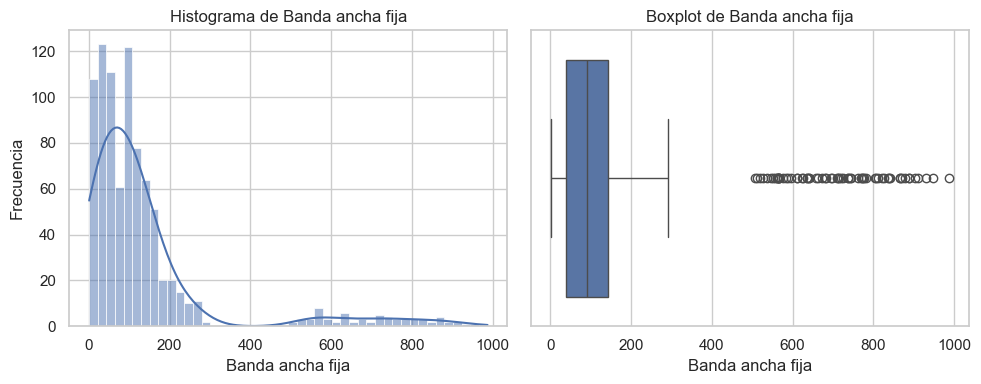

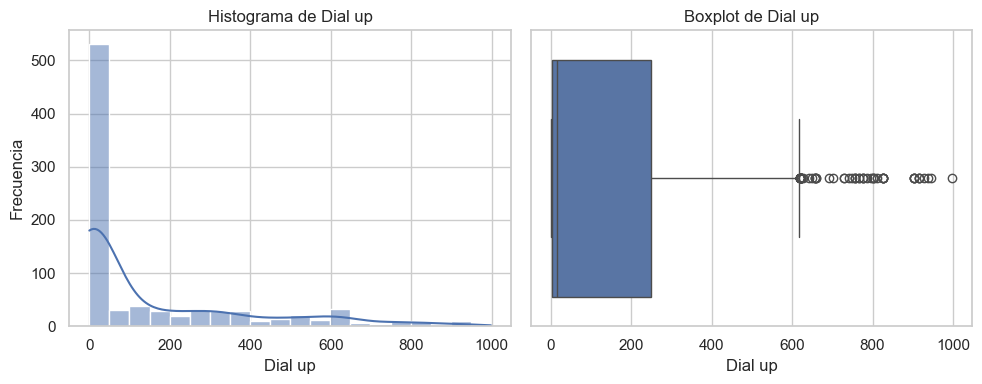

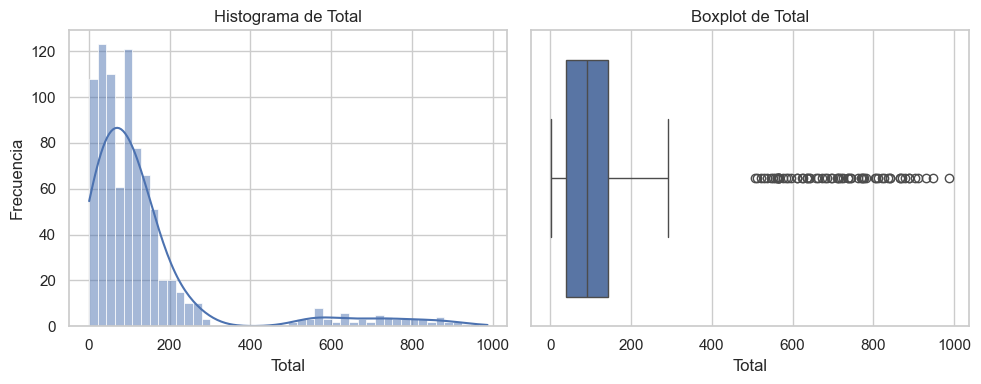

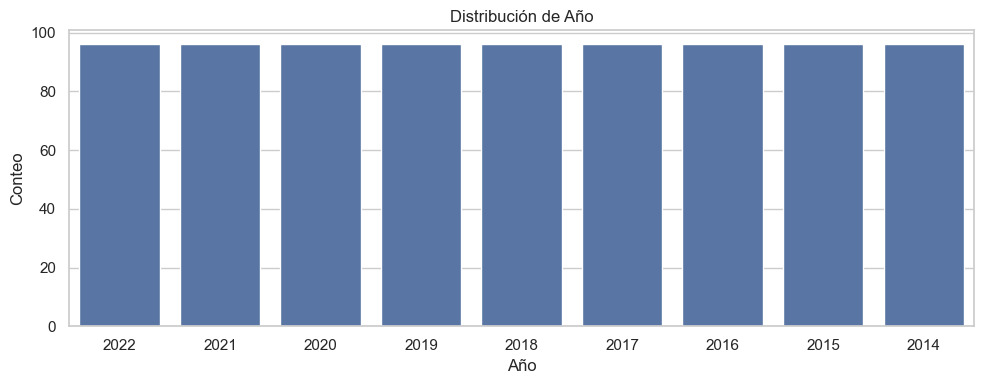

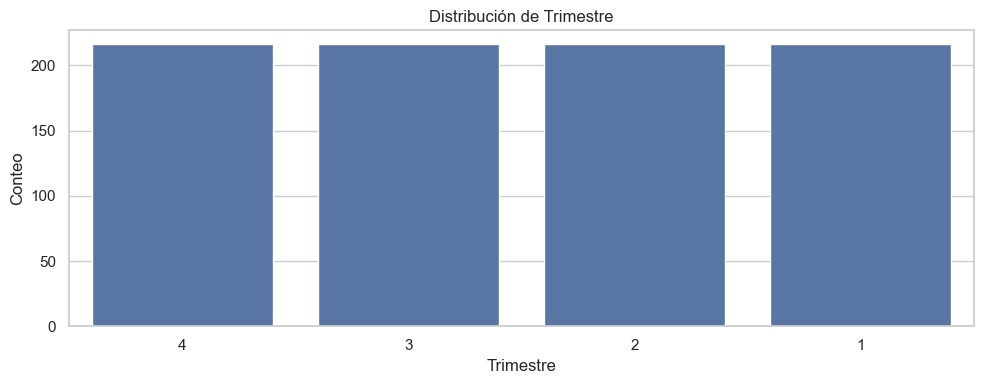

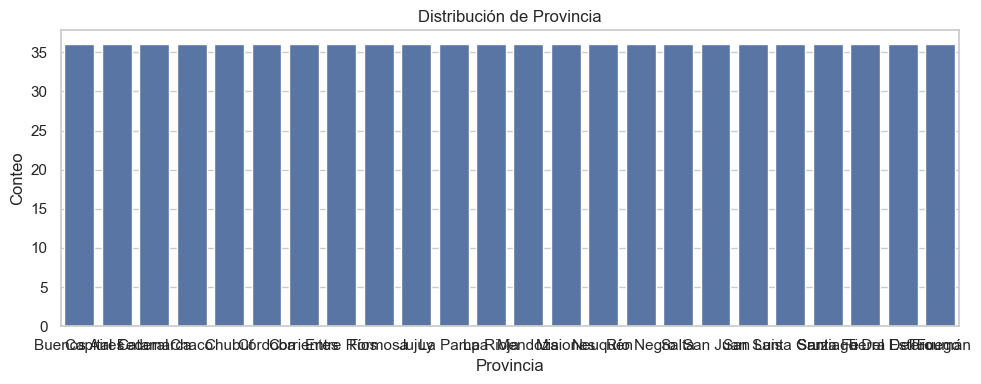

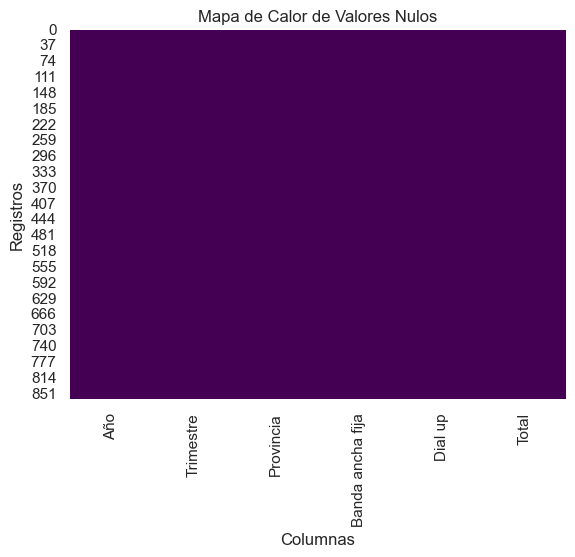

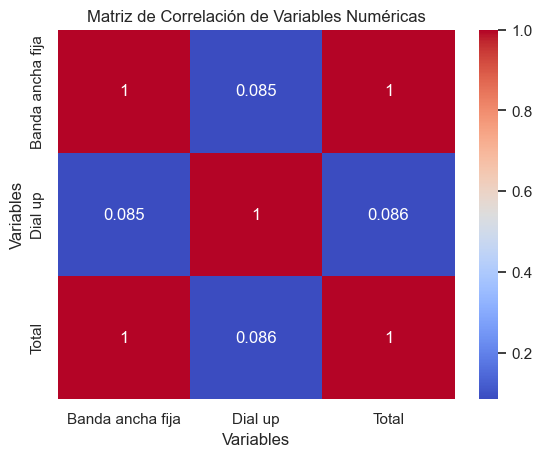

##################################################


In [40]:
informacion_dataframe('Accesos de Banda Ancha por Provincia', df_accesos_banda_por_provincia, visualizar=True, muestras=None, interactividad=True)


#### Resumen del Dataset

El conjunto de datos consiste en 864 registros, distribuidos en 6 columnas. Cada fila representa la cantidad de accesos de banda ancha fija y dial up por provincia, desglosados por año y trimestre. La columna 'Total' representa la suma de los accesos de banda ancha fija y dial up, aunque en este caso, dado que el dial up es una tecnología prácticamente obsoleta, 'Total' refleja principalmente el acceso de banda ancha fija.

#### Estadísticas Descriptivas

La distribución de accesos de banda ancha fija muestra una media de 137.33 con una desviación estándar de 180.81, indicando una variabilidad significativa entre las provincias. Esto sugiere una disparidad en la disponibilidad o adopción de la banda ancha fija en diferentes regiones.

En cuanto al dial up, aunque su media es ligeramente superior a la de banda ancha fija (150.25), la tecnología está en desuso, lo que implica que su mayor frecuencia en el dataset puede deberse a registros históricos o a áreas con acceso limitado a tecnologías más actuales.

#### Correlación

La correlación entre banda ancha fija y dial up es mínima (0.085), lo que es esperado ya que son tecnologías sustitutas más que complementarias. La perfecta correlación de la banda ancha fija con 'Total' es una redundancia matemática, ya que 'Total' incluye la banda ancha fija.

#### Análisis de Distribución

Los histogramas muestran que la mayoría de los accesos de banda ancha fija están concentrados en el rango más bajo (0-49), lo que podría indicar que muchas zonas aún tienen una adopción básica de internet. Similarmente, la mayoría de los valores de dial up se encuentran en el rango más bajo (0-49), lo que refuerza la idea de su decreciente relevancia.

#### Análisis de Boxplot

Los boxplots revelan varios outliers en ambos accesos de banda ancha fija y dial up, sugiriendo que hay provincias con accesos excepcionalmente altos, posiblemente áreas urbanas con mayor densidad de población y mejor infraestructura.

#### Distribución Temporal y Geográfica

La distribución uniforme de registros a lo largo de los años y trimestres permite un análisis equitativo en el tiempo. Cada provincia tiene la misma cantidad de registros (36), lo que facilita la comparación entre ellas.

#### Tendencias Temporales

C:\Users\Compumar\AppData\Local\Temp\ipykernel_16400\1896950850.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



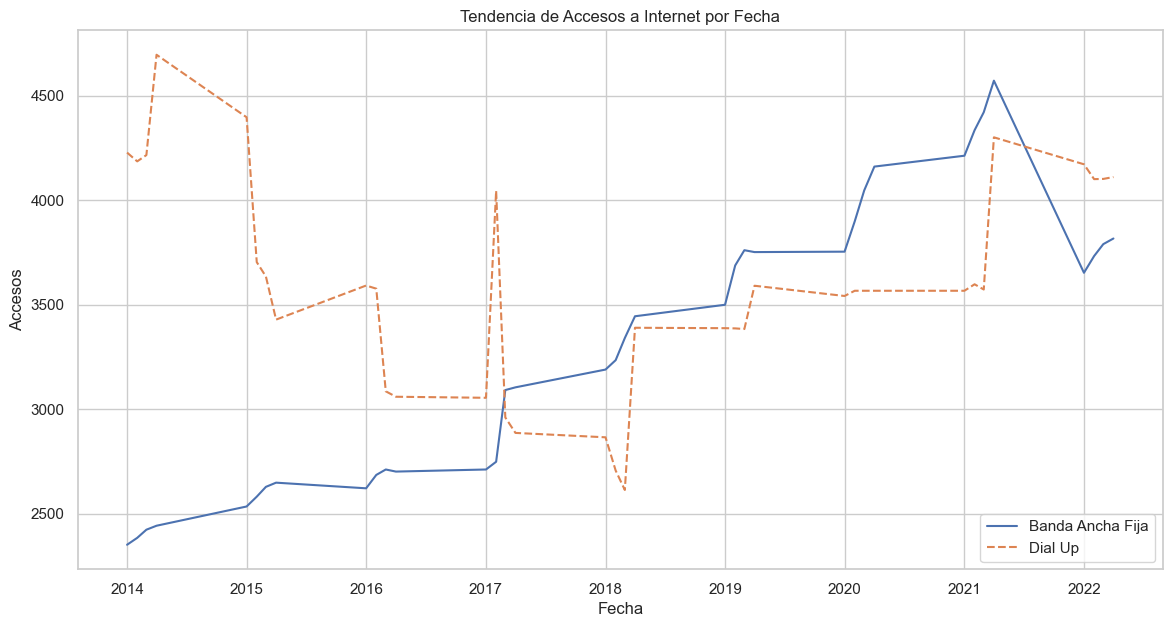

In [45]:
# Asegúrate de que las columnas de 'Año' y 'Trimestre' son del tipo correcto para manejar fechas
df_accesos_banda_por_provincia['Fecha'] = pd.to_datetime(df_accesos_banda_por_provincia['Año'] + ' ' + df_accesos_banda_por_provincia['Trimestre'])

# Agrupa los datos por fecha y calcula la suma de los accesos
tendencia_banda_ancha = df_accesos_banda_por_provincia.groupby('Fecha')['Banda ancha fija'].sum()
tendencia_dial_up = df_accesos_banda_por_provincia.groupby('Fecha')['Dial up'].sum()

# Grafica las tendencias
plt.figure(figsize=(14, 7))
plt.plot(tendencia_banda_ancha.index, tendencia_banda_ancha.values, label='Banda Ancha Fija')
plt.plot(tendencia_dial_up.index, tendencia_dial_up.values, label='Dial Up', linestyle='--')
plt.title('Tendencia de Accesos a Internet por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Accesos')
plt.legend()
plt.show()


In [46]:
# Unir las dos series en un DataFrame
df_tendencias = pd.DataFrame({'Banda ancha fija': tendencia_banda_ancha,
                              'Dial up': tendencia_dial_up}).reset_index()

In [47]:
df_tendencias

Fecha  Banda ancha fija  Dial up
0  2014-01-01            2351.0   4227.0
1  2014-02-01            2384.0   4185.0
2  2014-03-01            2423.0   4215.0
3  2014-04-01            2442.0   4695.0
4  2015-01-01            2534.0   4396.0
5  2015-02-01            2581.0   3703.0
6  2015-03-01            2628.0   3634.0
7  2015-04-01            2648.0   3428.0
8  2016-01-01            2621.0   3591.0
9  2016-02-01            2685.0   3576.0
10 2016-03-01            2711.0   3085.0
11 2016-04-01            2701.0   3059.0
12 2017-01-01            2711.0   3054.0
13 2017-02-01            2748.0   4044.0
14 2017-03-01            3091.0   2960.0
15 2017-04-01            3104.0   2886.0
16 2018-01-01            3189.0   2865.0
17 2018-02-01            3234.0   2706.0
18 2018-03-01            3340.0   2613.0
19 2018-04-01            3444.0   3389.0
20 2019-01-01            3499.0   3387.0
21 2019-02-01            3687.0   3386.0
22 2019-03-01            3760.0   3383.0
23 2019-04-01            3751.0   3590.0
24 2020-01-01            3753.0   3541.0
25 2020-02-01            3898.0   3566.0
26 2020-03-01            4046.0   3566.0
27 2020-04-01            4160.0   3566.0
28 2021-01-01            4212.0   3566.0
29 2021-02-01            4334.0   3597.0
30 2021-03-01            4420.0   3572.0
31 2021-04-01            4571.0   4300.0
32 2022-01-01            3652.0   4171.0
33 2022-02-01            3732.0   4100.0
34 2022-03-01            3789.0   4101.0
35 2022-04-01            3816.0   4110.0

Algunas observaciones basadas en los datos:

1. **Tendencia General**: Hay un aumento claro y constante en los accesos de banda ancha fija a lo largo del tiempo, lo que indica una adopción creciente de esta tecnología. Esto refleja una tendencia global hacia conexiones a Internet más rápidas y confiables.

2. **Dial Up**: Los números de dial up inicialmente son más altos que los de banda ancha fija, pero muestran una tendencia decreciente a lo largo del tiempo. Sin embargo, hay ciertos puntos, como en 2014-04, 2017-02, y 2021-04, donde hay picos inusuales. Esto podría deberse a factores estacionales o a eventos específicos que requirieron un mayor uso del dial up.

3. **Transición de Tecnología**: El declive gradual del dial up y el aumento de la banda ancha fija sugieren una transición de tecnologías de Internet más antiguas a más modernas. Es un reflejo de mejoras en la infraestructura y posiblemente de políticas que fomentan la actualización de las redes.

4. **Anomalías**: Existen puntos donde el dial up tiene un uso significativo a pesar de la tendencia a la baja, como en 2021-04, donde hay un aumento notable. Sería importante investigar qué factores contribuyen a estos aumentos, ya sea por falta de infraestructura de banda ancha o por preferencias en ciertas áreas.

5. **Estacionalidad**: No parece haber un patrón estacional claro en el uso de banda ancha o dial up basado en estos datos. Los picos en el uso de dial up no siguen un patrón anual constante que sugiera estacionalidad.

6. **Eventos Recientes**: En los últimos puntos de datos, particularmente en 2021 y 2022, hay fluctuaciones en el uso del dial up que podrían estar asociadas con eventos específicos o cambios en el comportamiento del consumidor, posiblemente influenciados por factores externos como la pandemia de COVID-19.

#### Comparación Geográfica

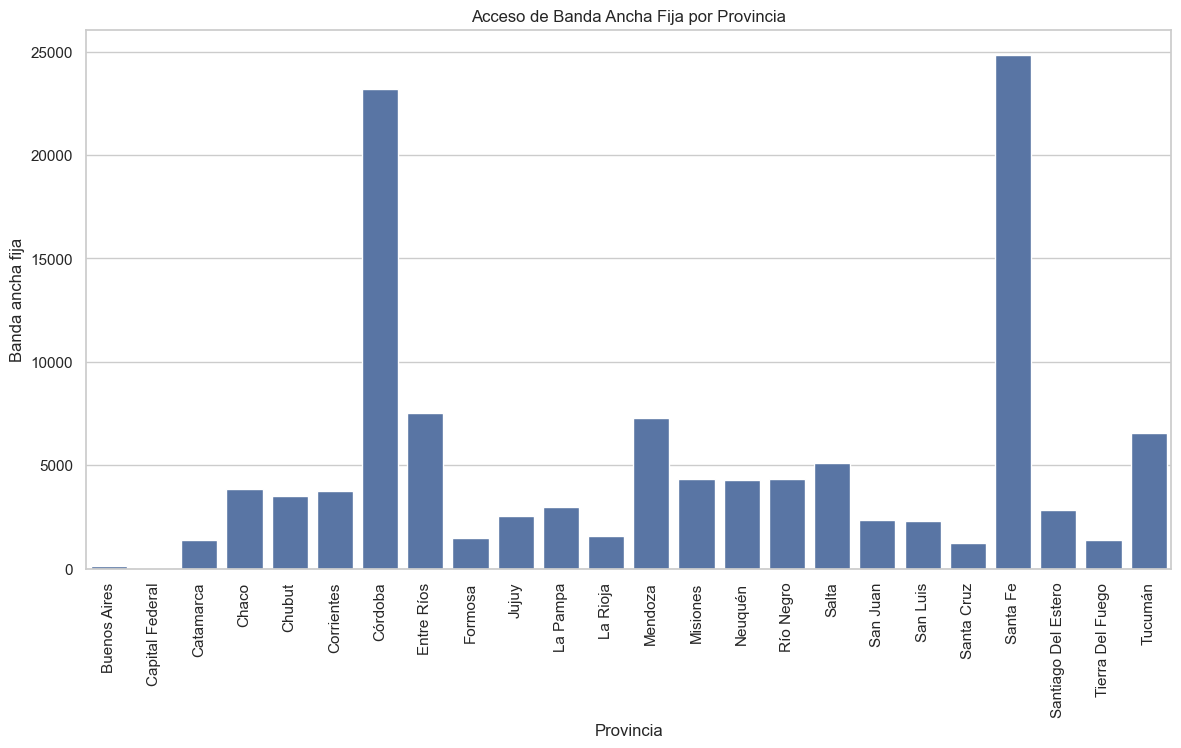

In [49]:
# Agrega las sumas totales por provincia
df_prov = df_accesos_banda_por_provincia.groupby('Provincia').agg({'Banda ancha fija': 'sum', 'Dial up': 'sum'}).reset_index()

# Gráfico de barras para visualizar la comparación
plt.figure(figsize=(14, 7))
sns.barplot(x='Provincia', y='Banda ancha fija', data=df_prov)
plt.xticks(rotation=90)
plt.title('Acceso de Banda Ancha Fija por Provincia')
plt.show()


In [50]:
df_prov

Provincia  Banda ancha fija  Dial up
0          Buenos Aires             131.0    346.0
1       Capital Federal              42.0    206.0
2             Catamarca            1382.0    328.0
3                 Chaco            3825.0    473.0
4                Chubut            3495.0  11164.0
5            Corrientes            3733.0    516.0
6               Córdoba           23200.0   4664.0
7            Entre Ríos            7519.0   2591.0
8               Formosa            1460.0    352.0
9                 Jujuy            2525.0     35.0
10             La Pampa            2980.0  11501.0
11             La Rioja            1591.0    478.0
12              Mendoza            7275.0   8891.0
13             Misiones            4324.0     49.0
14              Neuquén            4281.0   5385.0
15            Río Negro            4312.0  11437.0
16                Salta            5114.0    189.0
17             San Juan            2349.0  18297.0
18             San Luis            2309.0   9436.0
19           Santa Cruz            1229.0  11607.0
20             Santa Fe           24832.0  12339.0
21  Santiago Del Estero            2818.0    103.0
22     Tierra Del Fuego            1379.0  17998.0
23              Tucumán            6545.0   1428.0

Es intrigante ver cifras relativamente bajas para la banda ancha fija en Buenos Aires y la Capital Federal, áreas que uno esperaría que tuvieran números más altos debido a su mayor población y desarrollo económico. Estas son algunas reflexiones y posibles explicaciones:

1. **Errores de Datos**: Podría haber errores en la recopilación o entrada de datos.

2. **Muestra Representativa**: La muestra podria ser poco significativa y no reflejar la situación real de la banda ancha en estas provincias.

3. **Discrepancias Geográficas**: Puede haber un sesgo geográfico en la recopilación de datos que subestime las cifras de áreas más densamente pobladas y sobreestime las de áreas más rurales o remotas.

#### Relación entre Banda Ancha y Dial Up
Aunque hay baja correlación, un gráfico de dispersión puede ayudar a visualizar cualquier patrón potencial.

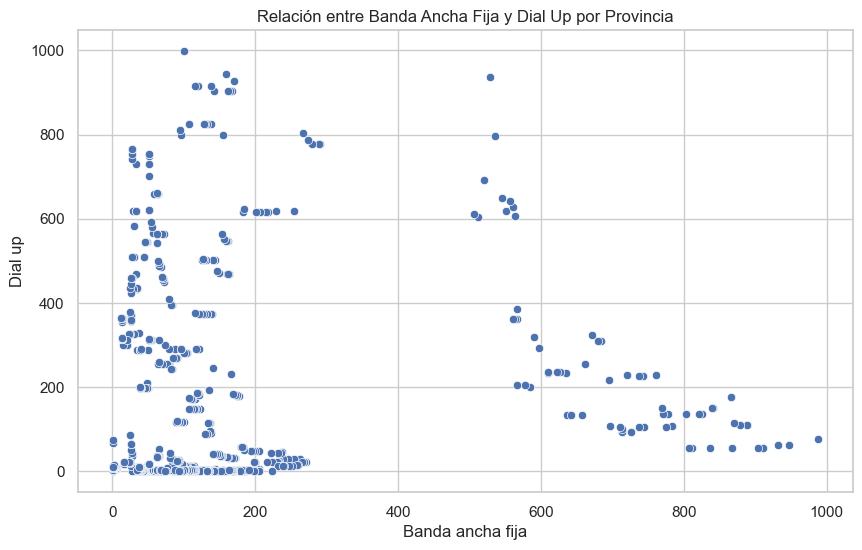

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Banda ancha fija', y='Dial up', data=df_accesos_banda_por_provincia)
plt.title('Relación entre Banda Ancha Fija y Dial Up por Provincia')
plt.show()

##### tabla resumen
Para generar una tabla resumen que capture la información clave del gráfico de dispersión entre Banda Ancha Fija y Dial Up por provincia, podríamos considerar incluir las siguientes columnas:

1. **Provincia**: El nombre de la provincia.
2. **Media de Banda Ancha Fija**: El promedio de conexiones de banda ancha fija por provincia.
3. **Media de Dial Up**: El promedio de conexiones dial up por provincia.
4. **Correlación**: Un valor que indique la correlación entre las conexiones de banda ancha fija y dial up en cada provincia.
5. **Número de Puntos**: Cuántos puntos de datos (es decir, registros) representan a cada provincia en el gráfico.
6. **Rango de Banda Ancha Fija**: El rango de valores de banda ancha fija en cada provincia.
7. **Rango de Dial Up**: El rango de valores de dial up en cada provincia.


In [55]:
import pandas as pd

# Calculando estadísticas descriptivas por provincia
resumen = df_accesos_banda_por_provincia.groupby('Provincia').agg({
    'Banda ancha fija': ['mean', 'min', 'max', 'count'],
    'Dial up': ['mean', 'min', 'max']
}).reset_index()

# Aplanando el MultiIndex de las columnas
resumen.columns = [' '.join(col).strip() for col in resumen.columns.values]

# Calculando la correlación por provincia
for provincia in df_accesos_banda_por_provincia['Provincia'].unique():
    provincia_data = df_accesos_banda_por_provincia[df_accesos_banda_por_provincia['Provincia'] == provincia]
    resumen.loc[resumen['Provincia'] == provincia, 'Correlación'] = provincia_data['Banda ancha fija'].corr(provincia_data['Dial up'])

# Renombrando columnas para claridad
resumen.rename(columns={
    'Banda ancha fija mean': 'Media Banda Ancha Fija',
    'Banda ancha fija min': 'Mínimo Banda Ancha Fija',
    'Banda ancha fija max': 'Máximo Banda Ancha Fija',
    'Banda ancha fija count': 'Número de Puntos',
    'Dial up mean': 'Media Dial Up',
    'Dial up min': 'Mínimo Dial Up',
    'Dial up max': 'Máximo Dial Up'
}, inplace=True)

# Ordenando por correlación para destacar las provincias con mayor/lower relación
resumen.sort_values('Correlación', ascending=False, inplace=True)

print(resumen)


              Provincia  Media Banda Ancha Fija  Mínimo Banda Ancha Fija  \
4                Chubut               97.083333                     62.0   
14              Neuquén              118.916667                     88.0   
12              Mendoza              202.083333                    164.0   
15            Río Negro              119.777778                     94.0   
6               Córdoba              644.444444                      1.0   
1       Capital Federal                1.166667                      1.0   
16                Salta              142.055556                     91.0   
13             Misiones              120.111111                     74.0   
8               Formosa               40.555556                     25.0   
21  Santiago Del Estero               78.277778                     33.0   
23              Tucumán              181.805556                    130.0   
22     Tierra Del Fuego               38.305556                     27.0   
7           

El análisis de los datos sugiere varias tendencias y anomalías interesantes:

1. **Variabilidad en Banda Ancha Fija**: Existe una gran variabilidad en la cantidad de conexiones de banda ancha fija entre las provincias, con Córdoba y Santa Fe mostrando los números más altos y la Capital Federal los más bajos. Estos números bajos en zonas urbanas densamente pobladas como Buenos Aires y la Capital Federal podrían indicar un error de datos o una representación no estándar que merece mayor investigación.

2. **Correlaciones Negativas**: Sorprendentemente, la mayoría de las correlaciones entre la banda ancha fija y el dial up son negativas. Esto podría interpretarse como que en lugares donde la banda ancha fija es más prevalente, el dial up es menos utilizado, lo cual tiene sentido desde una perspectiva tecnológica, ya que el dial up es una tecnología obsoleta.

3. **Anomalías Geográficas**: Algunas provincias como Chubut, Neuquén, Mendoza y Río Negro tienen correlaciones positivas y relativamente altas, lo que sugiere una relación más fuerte entre el uso de banda ancha fija y dial up. Esto podría deberse a factores regionales únicos, como la topografía que dificulta el acceso a la banda ancha fija, llevando a una dependencia continua del dial up.

4. **Outliers y Extremos**: Las provincias con los valores más altos y bajos en banda ancha fija y dial up deberían ser examinadas más de cerca para entender las causas de estos extremos. Por ejemplo, los números elevados en ciertas provincias podrían ser debido a programas de acceso a internet o inversiones en infraestructura, mientras que los bajos podrían reflejar problemas de acceso o error de datos.

5. **Escepticismo Sobre la Capital Federal y Buenos Aires**: Los números extremadamente bajos para la banda ancha fija y dial up en Buenos Aires y la Capital Federal son contraintuitivos, dada la alta urbanización y el desarrollo económico de estas áreas. Esto podría ser un error de recolección de datos, una interpretación errónea de lo que representan estos números o una señal de que los datos no están completos o actualizados.

6. **Posibles Errores de Datos**: La presencia de correlaciones negativas fuertes y valores extremadamente bajos en zonas urbanas indica la posibilidad de errores en los datos. Antes de sacar conclusiones definitivas, sería prudente verificar la integridad y la precisión de los datos con la fuente original o mediante una investigación adicional.


#### Análisis de Outliers


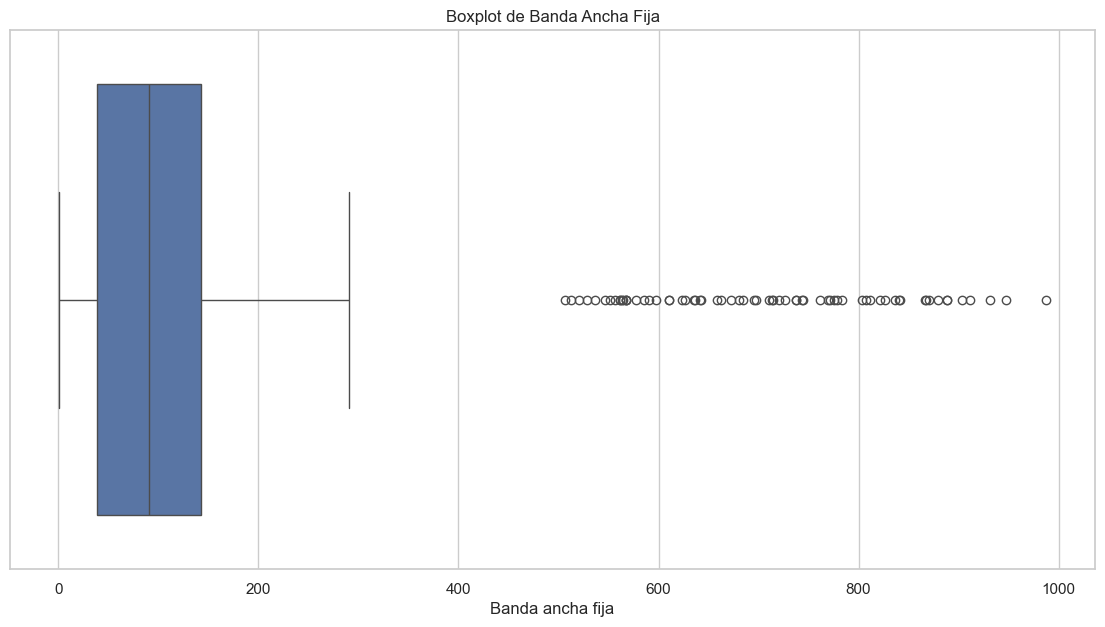

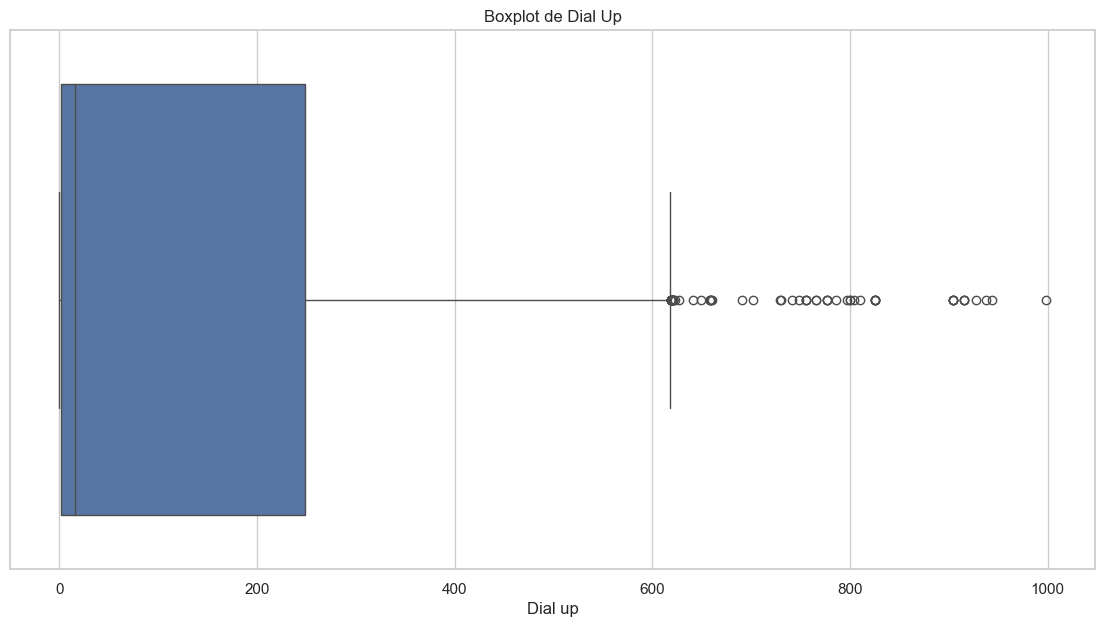

In [57]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Banda ancha fija', data=df_accesos_banda_por_provincia)
plt.title('Boxplot de Banda Ancha Fija')
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(x='Dial up', data=df_accesos_banda_por_provincia)
plt.title('Boxplot de Dial Up')
plt.show()


In [58]:

# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1_banda_ancha = df_accesos_banda_por_provincia['Banda ancha fija'].quantile(0.25)
Q3_banda_ancha = df_accesos_banda_por_provincia['Banda ancha fija'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR_banda_ancha = Q3_banda_ancha - Q1_banda_ancha

# Definir los límites para determinar los outliers
limite_inferior_banda_ancha = Q1_banda_ancha - 1.5 * IQR_banda_ancha
limite_superior_banda_ancha = Q3_banda_ancha + 1.5 * IQR_banda_ancha

# Encontrar los outliers
outliers_banda_ancha = df_accesos_banda_por_provincia[
    (df_accesos_banda_por_provincia['Banda ancha fija'] < limite_inferior_banda_ancha) |
    (df_accesos_banda_por_provincia['Banda ancha fija'] > limite_superior_banda_ancha)
]

# Repetir el proceso para Dial Up
Q1_dial_up = df_accesos_banda_por_provincia['Dial up'].quantile(0.25)
Q3_dial_up = df_accesos_banda_por_provincia['Dial up'].quantile(0.75)
IQR_dial_up = Q3_dial_up - Q1_dial_up
limite_inferior_dial_up = Q1_dial_up - 1.5 * IQR_dial_up
limite_superior_dial_up = Q3_dial_up + 1.5 * IQR_dial_up
outliers_dial_up = df_accesos_banda_por_provincia[
    (df_accesos_banda_por_provincia['Dial up'] < limite_inferior_dial_up) |
    (df_accesos_banda_por_provincia['Dial up'] > limite_superior_dial_up)
]


In [67]:
# Para configurar el máximo de filas que Pandas mostrará. 
pd.set_option('display.max_rows', None)


In [68]:
outliers_banda_ancha

Año Trimestre Provincia  Banda ancha fija  Dial up  Total      Fecha
20   2022         4  Santa Fe             888.0    110.0  888.0 2022-04-01
44   2022         3  Santa Fe             888.0    110.0  888.0 2022-03-01
68   2022         2  Santa Fe             879.0    110.0  879.0 2022-02-01
92   2022         1  Santa Fe             870.0    115.0  870.0 2022-01-01
101  2021         4   Córdoba             987.0     77.0  987.0 2021-04-01
116  2021         4  Santa Fe             866.0    176.0  866.0 2021-04-01
125  2021         3   Córdoba             947.0     62.0  947.0 2021-03-01
140  2021         3  Santa Fe             841.0    151.0  842.0 2021-03-01
149  2021         2   Córdoba             931.0     62.0  931.0 2021-02-01
164  2021         2  Santa Fe             840.0    151.0  841.0 2021-02-01
173  2021         1   Córdoba             911.0     55.0  911.0 2021-01-01
188  2021         1  Santa Fe             826.0    137.0  826.0 2021-01-01
197  2020         4   Córdoba             903.0     55.0  903.0 2020-04-01
212  2020         4  Santa Fe             821.0    137.0  821.0 2020-04-01
221  2020         3   Córdoba             867.0     55.0  867.0 2020-03-01
236  2020         3  Santa Fe             803.0    137.0  803.0 2020-03-01
245  2020         2   Córdoba             836.0     55.0  836.0 2020-02-01
260  2020         2  Santa Fe             778.0    137.0  778.0 2020-02-01
269  2020         1   Córdoba             811.0     55.0  811.0 2020-01-01
284  2020         1  Santa Fe             771.0    137.0  771.0 2020-01-01
293  2019         4   Córdoba             807.0     55.0  807.0 2019-04-01
308  2019         4  Santa Fe             769.0    150.0  769.0 2019-04-01
317  2019         3   Córdoba             783.0    107.0  783.0 2019-03-01
332  2019         3  Santa Fe             761.0    228.0  761.0 2019-03-01
341  2019         2   Córdoba             775.0    105.0  775.0 2019-02-01
356  2019         2  Santa Fe             743.0    226.0  743.0 2019-02-01
365  2019         1   Córdoba             744.0    105.0  744.0 2019-01-01
380  2019         1  Santa Fe             737.0    227.0  737.0 2019-01-01
389  2018         4   Córdoba             737.0    105.0  737.0 2018-04-01
404  2018         4  Santa Fe             720.0    229.0  720.0 2018-04-01
413  2018         3   Córdoba             726.0     94.0  726.0 2018-03-01
428  2018         3  Santa Fe             695.0    217.0  695.0 2018-03-01
437  2018         2   Córdoba             713.0     94.0  713.0 2018-02-01
452  2018         2  Santa Fe             684.0    309.0  685.0 2018-02-01
461  2018         1   Córdoba             714.0    101.0  714.0 2018-01-01
476  2018         1  Santa Fe             680.0    309.0  680.0 2018-01-01
485  2017         4   Córdoba             710.0    105.0  710.0 2017-04-01
500  2017         4  Santa Fe             672.0    323.0  672.0 2017-04-01
509  2017         3   Córdoba             697.0    108.0  697.0 2017-03-01
524  2017         3  Santa Fe             662.0    256.0  662.0 2017-03-01
533  2017         2   Córdoba             658.0    133.0  658.0 2017-02-01
548  2017         2  Santa Fe             567.0    362.0  567.0 2017-02-01
557  2017         1   Córdoba             641.0    133.0  641.0 2017-01-01
572  2017         1  Santa Fe             563.0    362.0  563.0 2017-01-01
581  2016         4   Córdoba             636.0    133.0  637.0 2016-04-01
596  2016         4  Santa Fe             561.0    362.0  562.0 2016-04-01
605  2016         3   Córdoba             642.0    133.0  643.0 2016-03-01
620  2016         3  Santa Fe             567.0    386.0  567.0 2016-03-01
629  2016         2   Córdoba             635.0    234.0  635.0 2016-02-01
644  2016         2  Santa Fe             564.0    607.0  564.0 2016-02-01
653  2016         1   Córdoba             610.0    234.0  610.0 2016-01-01
668  2016         1  Santa Fe             551.0    618.0  552.0 2016-01-01
677  2015         4   Córdoba  

In [69]:
outliers_dial_up

Año Trimestre         Provincia  Banda ancha fija  Dial up  Total  \
4    2022         4            Chubut             168.0    904.0  169.0   
12   2022         4           Mendoza             291.0    777.0  292.0   
28   2022         3            Chubut             165.0    904.0  166.0   
36   2022         3           Mendoza             289.0    777.0  290.0   
52   2022         2            Chubut             162.0    904.0  163.0   
60   2022         2           Mendoza             279.0    777.0  280.0   
76   2022         1            Chubut             171.0    927.0  172.0   
84   2022         1           Mendoza             274.0    786.0  275.0   
100  2021         4            Chubut             159.0    944.0  160.0   
108  2021         4           Mendoza             267.0    804.0  268.0   
124  2021         3            Chubut             155.0    800.0  156.0   
132  2021         3           Mendoza             255.0    619.0  256.0   
148  2021         2            Chubut             138.0    825.0  139.0   
156  2021         2           Mendoza             229.0    619.0  230.0   
172  2021         1            Chubut             132.0    825.0  132.0   
196  2020         4            Chubut             130.0    825.0  131.0   
220  2020         3            Chubut             129.0    825.0  130.0   
244  2020         2            Chubut             108.0    825.0  109.0   
268  2020         1            Chubut              96.0    800.0   97.0   
292  2019         4            Chubut              95.0    810.0   96.0   
300  2019         4           Mendoza             185.0    623.0  186.0   
327  2019         3         Río Negro             143.0    904.0  144.0   
351  2019         2         Río Negro             138.0    915.0  139.0   
375  2019         1         Río Negro             120.0    915.0  121.0   
399  2018         4         Río Negro             116.0    915.0  117.0   
425  2018         3          San Juan              64.0    658.0   64.0   
449  2018         2          San Juan              63.0    658.0   64.0   
473  2018         1          San Juan              63.0    658.0   63.0   
497  2017         4          San Juan              58.0    659.0   59.0   
521  2017         3          San Juan              62.0    660.0   62.0   
543  2017         2         Río Negro             101.0    998.0  102.0   
545  2017         2          San Juan              51.0    620.0   52.0   
550  2017         2  Tierra Del Fuego              32.0    619.0   33.0   
569  2017         1          San Juan              51.0    620.0   52.0   
574  2017         1  Tierra Del Fuego              32.0    619.0   33.0   
593  2016         4          San Juan              51.0    620.0   52.0   
598  2016         4  Tierra Del Fuego              32.0    619.0   33.0   
617  2016         3          San Juan              51.0    620.0   52.0   
622  2016         3  Tierra Del Fuego              31.0    619.0   32.0   
641  2016         2          San Juan              51.0    621.0   52.0   
646  2016         2  Tierra Del Fuego              31.0    619.0   31.0   
665  2016         1          San Juan              51.0    621.0   52.0   
670  2016         1  Tierra Del Fuego              30.0    619.0   30.0   
689  2015         4          San Juan              51.0    621.0   52.0   
692  2015         4          Santa Fe             561.0    627.0  562.0   
694  2015         4  Tierra Del Fuego              29.0    619.0   30.0   
713  2015         3          San Juan              51.0    621.0   52.0   
716  2015         3          Santa Fe             556.0    641.0  557.0   
718  2015         3  Tierra Del Fuego              33.0    619.0   34.0   
737  2015         2          San Juan              51.0    621.0   52.0   
740  2015         2          Santa Fe             546.0    649.0  546.0   
742  2015         2  Tierra Del Fuego              33.0    619.0   34.0   
761  2015         1          Sa


##### Análisis de Outliers de Banda Ancha Fija:
1. **Concentración Geográfica**: Los valores atípicos para la banda ancha fija están concentrados principalmente en las provincias de Santa Fe y Córdoba. Esto podría indicar que estas provincias tienen una infraestructura de telecomunicaciones particularmente robusta o una alta demanda de servicios de internet de banda ancha, lo que resulta en valores más altos en comparación con otras regiones.

2. **Consistencia Temporal**: Los altos valores para Santa Fe se mantienen a lo largo de diferentes trimestres y años, lo que sugiere que no son anomalías puntuales sino una tendencia consistente. Similarmente, Córdoba muestra valores altos, especialmente en 2021, lo que podría corresponder a inversiones específicas o a un incremento en la adopción de servicios de banda ancha en ese período.

3. **Variabilidad**: Aunque hay una consistencia en los valores altos, también hay fluctuaciones. Por ejemplo, los valores en Córdoba varían entre 610 y 987. Esto podría deberse a cambios en la medición, en la capacidad de la red, o en el comportamiento del usuario.

##### Análisis de Outliers de Dial Up:
1. **Declive Tecnológico**: Los valores atípicos de dial up son especialmente interesantes porque el dial up es una tecnología obsoleta en la mayoría de las áreas urbanas. Estos valores podrían representar zonas rurales o remotas donde la banda ancha no está disponible o es demasiado costosa.

2. **Concentración en Chubut y Mendoza**: Similar a la banda ancha fija, hay una concentración geográfica de valores atípicos, pero para el dial up, se localizan en Chubut y Mendoza. Esto podría reflejar limitaciones en la infraestructura de telecomunicaciones o un retraso en la modernización de la red en estas provincias.

3. **Valores Elevados**: Algunos de los valores de dial up son extremadamente altos (por ejemplo, 904 en Chubut), lo cual es inusual ya que el dial up generalmente soporta menos conexiones simultáneas en comparación con la banda ancha. Esto podría requerir una investigación adicional para entender las razones detrás de estos números.

### Distribución del Total de Accesos

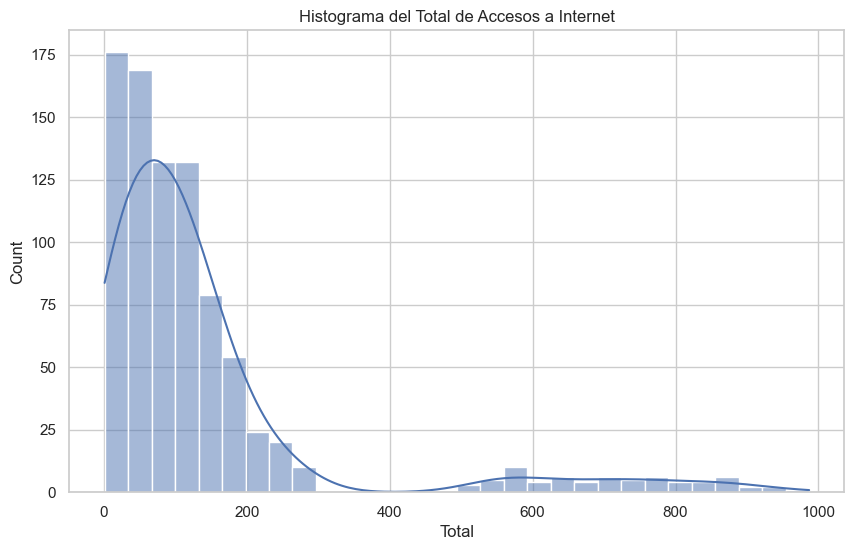

In [72]:
plt.figure(figsize=(10, 6))
sns.histplot(df_accesos_banda_por_provincia['Total'], bins=30, kde=True)
plt.title('Histograma del Total de Accesos a Internet')
plt.show()

In [77]:

bin_ranges = pd.cut(df_accesos_banda_por_provincia['Total'], bins=30)

# calculamos el conteo para cada rango
bin_counts = bin_ranges.value_counts().sort_index()

# Convertimos en DataFrame para una mejor visualización
bin_counts_df = pd.DataFrame(bin_counts)
bin_counts_df.reset_index(inplace=True)
bin_counts_df.columns = ['Rango', 'Conteo']

# Mostrar la tabla
print(bin_counts_df)


                 Rango  Conteo
0      (0.014, 33.867]     176
1     (33.867, 66.733]     169
2       (66.733, 99.6]     132
3      (99.6, 132.467]     132
4   (132.467, 165.333]      79
5     (165.333, 198.2]      54
6     (198.2, 231.067]      24
7   (231.067, 263.933]      20
8     (263.933, 296.8]      10
9     (296.8, 329.667]       0
10  (329.667, 362.533]       0
11    (362.533, 395.4]       0
12    (395.4, 428.267]       0
13  (428.267, 461.133]       0
14    (461.133, 494.0]       0
15    (494.0, 526.867]       3
16  (526.867, 559.733]       5
17    (559.733, 592.6]      10
18    (592.6, 625.467]       4
19  (625.467, 658.333]       6
20    (658.333, 691.2]       4
21    (691.2, 724.067]       6
22  (724.067, 756.933]       5
23    (756.933, 789.8]       6
24    (789.8, 822.667]       4
25  (822.667, 855.533]       4
26    (855.533, 888.4]       6
27    (888.4, 921.267]       2
28  (921.267, 954.133]       2
29    (954.133, 987.0]       1


In [74]:
# Calcular estadísticas descriptivas
summary_table = df_accesos_banda_por_provincia['Total'].describe()

# Convertir el resultado en un DataFrame para una mejor visualización
summary_table_df = pd.DataFrame(summary_table).transpose()

# moda
mode = df_accesos_banda_por_provincia['Total'].mode().values[0]
summary_table_df['mode'] = mode

# cálculo de la asimetría y la curtosis:
skewness = df_accesos_banda_por_provincia['Total'].skew()
kurtosis = df_accesos_banda_por_provincia['Total'].kurt()

summary_table_df['skewness'] = skewness
summary_table_df['kurtosis'] = kurtosis

# Mostrar la tabla resumen
print(summary_table_df)


       count        mean         std  min    25%   50%     75%    max  mode  \
Total  864.0  137.636574  180.798813  1.0  39.75  91.0  143.25  987.0   1.0   

       skewness  kurtosis  
Total  2.748135  7.250922  


Análisis:

1. **Concentración de Datos**: La mayoría de los datos se concentran en el rango más bajo (0-33.867), con 176 ocurrencias, lo que sugiere que una gran cantidad de los totales de accesos a internet son muy bajos. 

2. **Disminución progresiva**: A medida que aumentamos en los rangos de `Total`, el número de ocurrencias disminuye significativamente, lo que indica que altos volúmenes de acceso son menos comunes.

3. **Intervalos vacíos**: Existen rangos sin datos (por ejemplo, de 296.8 a 329.667), lo que puede indicar que ciertos volúmenes de acceso a internet no se presentan en la muestra o son muy raros.

4. **Estadísticos Descriptivos**: 
   - La media (mean) es de aproximadamente 137.64, lo que indica que en promedio hay unos 138 accesos a internet en la muestra.
   - La desviación estándar (std) es alta (alrededor de 180.80), lo que sugiere una gran variabilidad en los datos de accesos a internet.
   - La mediana (50%) es 91, lo cual es significativamente menor que la media, lo que indica una distribución sesgada hacia la derecha.
   - El mínimo (min) y máximo (max) son 1 y 987, respectivamente, lo que muestra un amplio rango en los datos.

5. **Moda**: La moda es 1, lo que significa que el valor más frecuente de accesos a internet en la muestra es 1, lo que puede interpretarse como que hay una cantidad significativa de registros con un solo acceso.

6. **Sesgo (Skewness)**: El coeficiente de asimetría es positivo (aproximadamente 2.748), lo que confirma el sesgo hacia la derecha observado visualmente en el histograma. Esto significa que hay una cola más larga hacia los valores más altos de accesos.

7. **Curtosis (Kurtosis)**: El valor de curtosis es significativamente mayor que 0 (aproximadamente 7.251), lo que indica una distribución leptocúrtica; es decir, hay una concentración de valores alrededor de la media más pronunciada que en una distribución normal y colas más pesadas, sugiriendo la presencia de outliers.

En resumen, los datos de accesos a internet están altamente concentrados en valores bajos, con una tendencia a tener valores extremos mucho más altos que el promedio.

#### Descriptivos por Categorías

In [82]:
df_accesos_banda_por_provincia.head(10)

Año Trimestre        Provincia  Banda ancha fija  Dial up  Total  \
0  2022         4     Buenos Aires               5.0      6.0    5.0   
1  2022         4  Capital Federal               2.0      2.0    2.0   
2  2022         4        Catamarca              71.0      1.0   71.0   
3  2022         4            Chaco             144.0      5.0  144.0   
4  2022         4           Chubut             168.0    904.0  169.0   
5  2022         4          Córdoba               1.0     68.0    1.0   
6  2022         4       Corrientes             155.0      4.0  155.0   
7  2022         4       Entre Ríos             271.0     22.0  271.0   
8  2022         4          Formosa              62.0      0.0   62.0   
9  2022         4            Jujuy             118.0      0.0  118.0   

       Fecha  
0 2022-04-01  
1 2022-04-01  
2 2022-04-01  
3 2022-04-01  
4 2022-04-01  
5 2022-04-01  
6 2022-04-01  
7 2022-04-01  
8 2022-04-01  
9 2022-04-01

In [83]:
# Estadísticas por año
df_accesos_banda_por_provincia.groupby('Año')[['Banda ancha fija', 'Dial up']].describe()

# Estadísticas por provincia
df_accesos_banda_por_provincia.groupby('Provincia')[['Banda ancha fija', 'Dial up']].describe()



Banda ancha fija                                         \
                               count        mean         std    min     25%   
Provincia                                                                     
Buenos Aires                    36.0    3.638889    0.723198    3.0    3.00   
Capital Federal                 36.0    1.166667    0.377964    1.0    1.00   
Catamarca                       36.0   38.388889   14.687755   24.0   26.00   
Chaco                           36.0  106.250000   26.543092   63.0   87.75   
Chubut                          36.0   97.083333   37.269961   62.0   62.75   
Corrientes                      36.0  103.694444   25.125763   62.0   86.75   
Córdoba                         36.0  644.444444  257.802410    1.0  606.75   
Entre Ríos                      36.0  208.861111   42.946580  134.0  177.25   
Formosa                         36.0   40.555556   12.867333   25.0   28.00   
Jujuy                           36.0   70.138889   33.092211   34.0   40.75   
La Pampa                        36.0   82.777778   17.510994   54.0   67.50   
La Rioja                        36.0   44.194444   25.608949   16.0   16.75   
Mendoza                         36.0  202.083333   39.013825  164.0  169.00   
Misiones                        36.0  120.111111   33.513987   74.0   95.25   
Neuquén                         36.0  118.916667   19.961928   88.0  107.25   
Río Negro                       36.0  119.777778   22.609873   94.0   99.75   
Salta                           36.0  142.055556   40.513098   91.0  104.25   
San Juan                        36.0   65.250000   15.703275   51.0   51.00   
San Luis                        36.0   64.138889   51.386020   12.0   13.00   
Santa Cruz                      36.0   34.138889    9.274089   24.0   26.00   
Santa Fe                        36.0  689.777778  131.144655  506.0  561.00   
Santiago Del Estero             36.0   78.277778   35.669604   33.0   38.75   
Tierra Del Fuego                36.0   38.305556    8.918102   27.0   31.00   
Tucumán                         36.0  181.805556   42.500971  130.0  148.50   

                                          Dial up                          \
                       50%     75%    max   count        mean         std   
Provincia                                                                   
Buenos Aires           3.5    4.00    5.0    36.0    9.611111    3.491032   
Capital Federal        1.0    1.00    2.0    36.0    5.722222    3.939624   
Catamarca             34.0   50.50   71.0    36.0    9.111111    7.158523   
Chaco                100.5  135.25  144.0    36.0   13.138889   10.226444   
Chubut                86.5  129.25  171.0    36.0  310.111111  416.768163   
Corrientes            98.5  123.75  155.0    36.0   14.333333   12.970296   
Córdoba              677.5  789.00  987.0    36.0  129.555556   75.886925   
Entre Ríos           202.5  242.50  271.0    36.0   71.972222   69.012001   
Formosa               45.0   49.25   69.0    36.0    9.777778   22.848709   
Jujuy                 45.0  106.25  119.0    36.0    0.972222    0.909823   
La Pampa              83.0   94.75  116.0    36.0  319.472222  167.988007   
La Rioja              51.0   53.00   87.0    36.0   13.277778    7.759275   
Mendoza              195.0  219.25  291.0    36.0  246.972222  334.885950   
Misiones             107.0  144.00  186.0    36.0    1.361111    2.809705   
Neuquén              115.0  130.00  163.0    36.0  149.583333  201.161396   
Río Negro            111.5  141.00  162.0    36.0  317.694444  347.533416   
Salta                133.5  182.50  206.0    36.0    5.250000    7.762087   
San Juan              62.5   74.00  104.0    36.0  508.250000  189.863165   
San Luis              47.5  118.25  135.0    36.0  262.111111   79.283498   
Santa Cruz            31.5   39.25   50.0    36.0  322.416667  101.804680   
Santa Fe             689.5  807.50  888.0    36.0  342.750000  231.702812   
Santiago Del Estero   85.0  112.50  13

- **Banda Ancha Fija**:
  - La mayoría de las provincias tienen un promedio de conexiones de banda ancha fija de dos dígitos, lo que sugiere una cobertura moderada.
  - Córdoba y Santa Fe se destacan con una media significativamente alta de conexiones de banda ancha fija (644 y 690 respectivamente), lo que podría indicar una mayor urbanización o inversión en infraestructura.
  - Las provincias con el promedio más bajo de conexiones de banda ancha fija son Capital Federal y Tierra del Fuego, lo que podría ser el resultado de una menor población o de una menor necesidad de conexiones fijas debido a una mayor prevalencia de conexiones móviles o alternativas.

- **Dial Up**:
  - Hay una gran variabilidad en las conexiones de dial up entre las provincias. Por ejemplo, Chubut tiene un promedio muy alto de conexiones de dial up (310), lo que es inusual dado que el dial up es una tecnología obsoleta en muchas áreas.
  - En contraste, Jujuy y Santiago del Estero tienen un promedio muy bajo de conexiones de dial up, lo que podría reflejar una transición más rápida a otras tecnologías de internet o una menor dependencia de las conexiones de internet en general.

- **Variabilidad**:
  - La desviación estándar (std) proporciona una idea de la variabilidad de las conexiones en cada provincia. Por ejemplo, Córdoba muestra una gran variabilidad en banda ancha fija, mientras que Capital Federal tiene muy poca. Esto podría indicar una distribución más homogénea de las conexiones en algunas áreas y una distribución más desigual en otras.

- **Extremos**:
  - El mínimo y el máximo ofrecen una vista de los extremos en los datos. Por ejemplo, algunas provincias como Córdoba tienen un mínimo muy bajo y un máximo muy alto para banda ancha fija, lo que sugiere que hay áreas con acceso muy limitado y otras con acceso muy amplio.

### Serie Trimestral por Tecnología

In [84]:
df_serie_trimestral_tecnologia

Año  Trimestre  ADSL  Cablemodem  Fibra óptica  Wireless  Otros  Total  \
0   2022          4     1           6             3       573    222     11   
1   2022          3     1           6             3       557    235     11   
2   2022          2     1           6             3       556    232     11   
3   2022          1     2           6             2       546    252     11   
4   2021          4     2           6             2       523    253     10   
5   2021          3     2           6             2       492    250     10   
6   2021          2     2           6             1       477    254     10   
7   2021          1     2           5             1       435    250     10   
8   2020          4     2           5             1       422    253     10   
9   2020          3     2           5             1       413    249      9   
10  2020          2     2           5             1       377    247      9   
11  2020          1     2           5             1       352    209      9   
12  2019          4     2           5           941       340    213      9   
13  2019          3     3           5           852       338    264      9   
14  2019          2     3           5           761       308    265      9   
15  2019          1     3           4           637       276    166      9   
16  2018          4     3           4           388       264    178      8   
17  2018          3     4           4           247       246     94      8   
18  2018          2     4           4           226       194     95      8   
19  2018          1     4           4           217       165     99      8   
20  2017          4     4           4           211       156    101      8   
21  2017          3     4           4           194       106    132      8   
22  2017          2     4           3           181        86     56      7   
23  2017          1     4           3           180        85     56      7   
24  2016          4     4           3           178        85     55      7   
25  2016          3     4           3           170        81     54      7   
26  2016          2     4           3           168        85     59      7   
27  2016          1     4           3           164        85     59      7   
28  2015          4     4           3           139        86     59      7   
29  2015          3     4           3           163        85     59      7   
30  2015          2     4           3           151        82     59      7   
31  2015          1     4           3           168        79     66      7   
32  2014          4     4           3           150        77     72      7   
33  2014          3     4           3           155        85     70      7   
34  2014          2     4           2           149        72     72      6   
35  2014          1     4           2           150        71     73      6   

          Periodo  
0    Oct-Dic 2022  
1   Jul-Sept 2022  
2    Abr-Jun 2022  
3    Ene-Mar 2022  
4    Oct-Dic 2021  
5   Jul-Sept 2021  
6    Abr-Jun 2021  
7    Ene-Mar 2021  
8    Oct-Dic 2020  
9   Jul-Sept 2020  
10   Abr-Jun 2020  
11   Ene-Mar 2020  
12   Oct-Dic 2019  
13  Jul-Sept 2019  
14   Abr-Jun 2019  
15   Ene-Mar 2019  
16   Oct-Dic 2018  
17  Jul-Sept 2018  
18   Abr-Jun 2018  
19   Ene-Mar 2018  
20   Oct-Dic 2017  
21  Jul-Sept 2017  
22   Abr-Jun 2017  
23   Ene-Mar 2017  
24   Oct-Dic 2016  
25  Jul-Sept 2016  
26   Abr-Jun 2016  
27   Ene-Mar 2016  
28   Oct-Dic 2015  
29  Jul-Sept 2015  
30   Abr-Jun 2015  
31   Ene-Mar 2015  
32   Oct-Dic 2014  
33  Jul-Sept 2014  
34   Abr-Jun 2014  
35   Ene-Mar 2014

Analizando: Serie Trimestral por Tecnología
Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Año           36 non-null     int64 
 1   Trimestre     36 non-null     int64 
 2   ADSL          36 non-null     int64 
 3   Cablemodem    36 non-null     int64 
 4   Fibra óptica  36 non-null     int64 
 5   Wireless      36 non-null     int64 
 6   Otros         36 non-null     int64 
 7   Total         36 non-null     int64 
 8   Periodo       36 non-null     object
dtypes: int64(8), object(1)
memory usage: 2.7+ KB
None

Estadísticas Descriptivas:
                Año  Trimestre       ADSL  Cablemodem  Fibra óptica  \
count     36.000000  36.000000  36.000000   36.000000     36.000000   
unique          NaN        NaN        NaN         NaN           NaN   
top             NaN        NaN        NaN         NaN        

Año  Trimestre  ADSL  Cablemodem  Fibra óptica  Wireless  Otros  Total  \
0   2022          4     1           6             3       573    222     11   
1   2022          3     1           6             3       557    235     11   
2   2022          2     1           6             3       556    232     11   
3   2022          1     2           6             2       546    252     11   
4   2021          4     2           6             2       523    253     10   
31  2015          1     4           3           168        79     66      7   
32  2014          4     4           3           150        77     72      7   
33  2014          3     4           3           155        85     70      7   
34  2014          2     4           2           149        72     72      6   
35  2014          1     4           2           150        71     73      6   

          Periodo  
0    Oct-Dic 2022  
1   Jul-Sept 2022  
2    Abr-Jun 2022  
3    Ene-Mar 2022  
4    Oct-Dic 2021  
31   Ene-Mar 2015  
32   Oct-Dic 2014  
33  Jul-Sept 2014  
34   Abr-Jun 2014  
35   Ene-Mar 2014


Valores nulos por columna:
              Cantidad  Porcentaje
Año                  0         0.0
Trimestre            0         0.0
ADSL                 0         0.0
Cablemodem           0         0.0
Fibra óptica         0         0.0
Wireless             0         0.0
Otros                0         0.0
Total                0         0.0
Periodo              0         0.0

Número de filas duplicadas: 0

Número de valores únicos en 'Periodo': 36
Valor más común en 'Periodo': Abr-Jun 2014


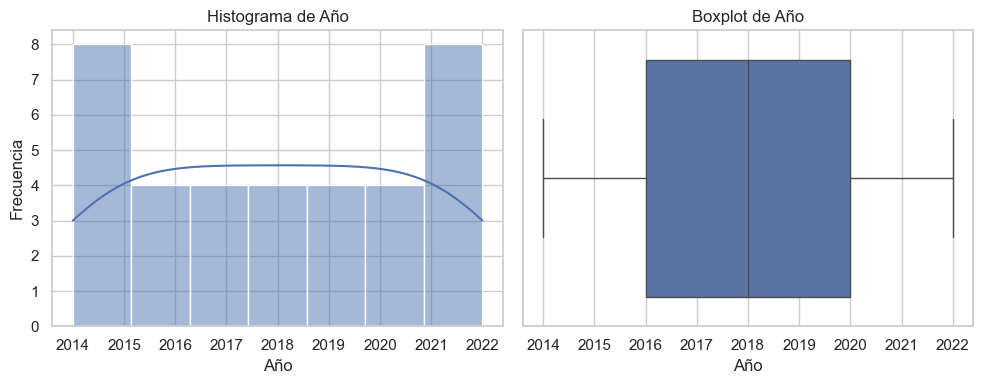

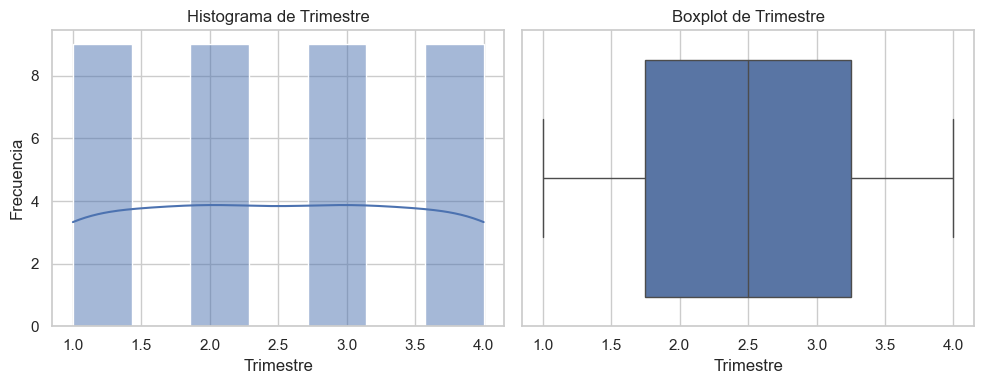

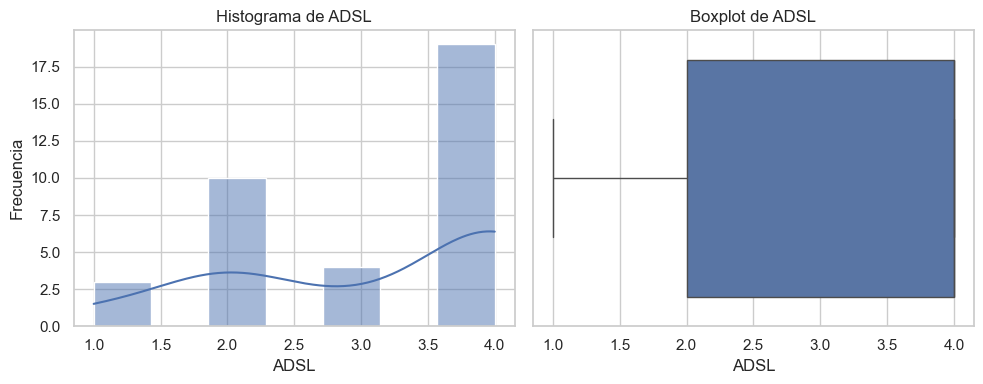

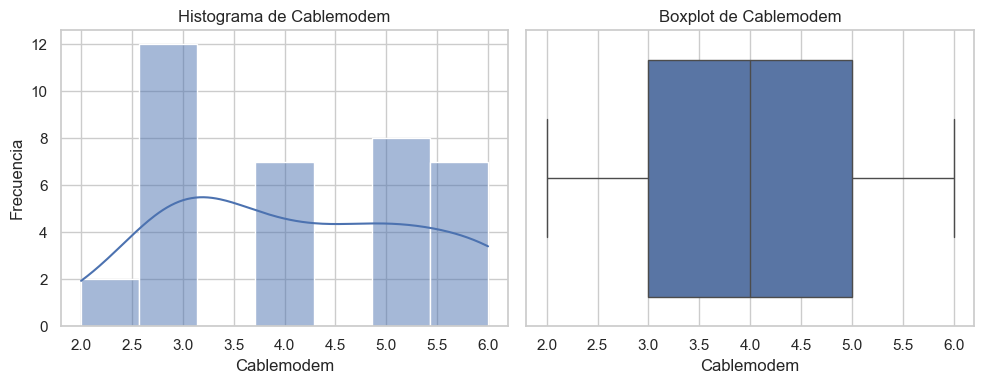

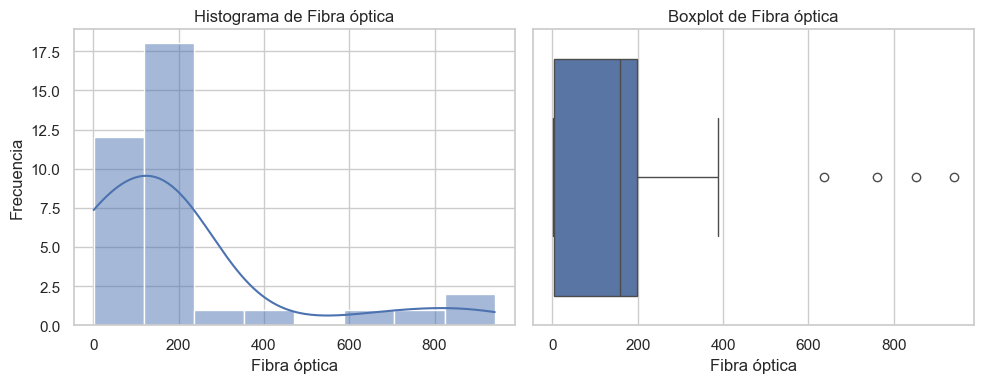

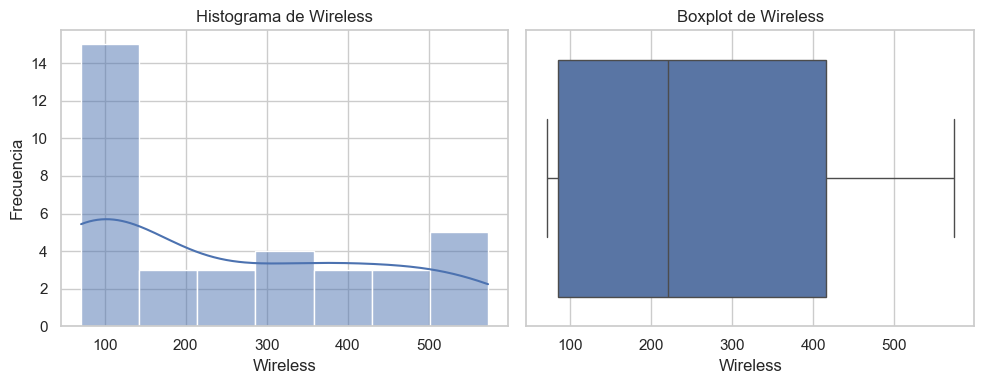

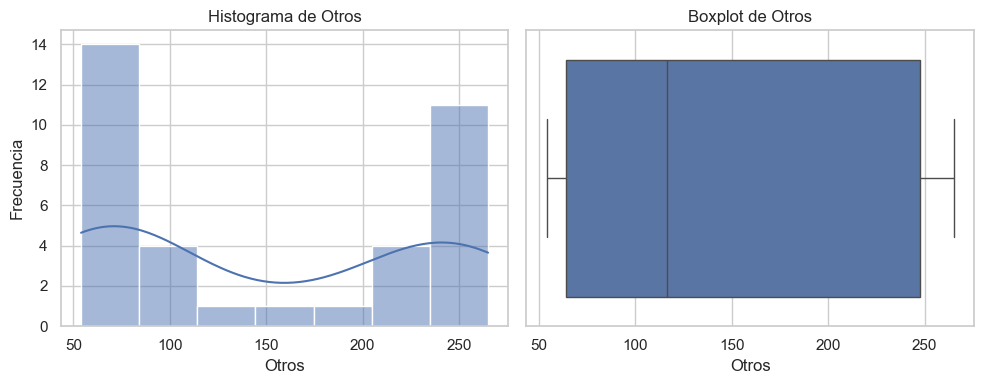

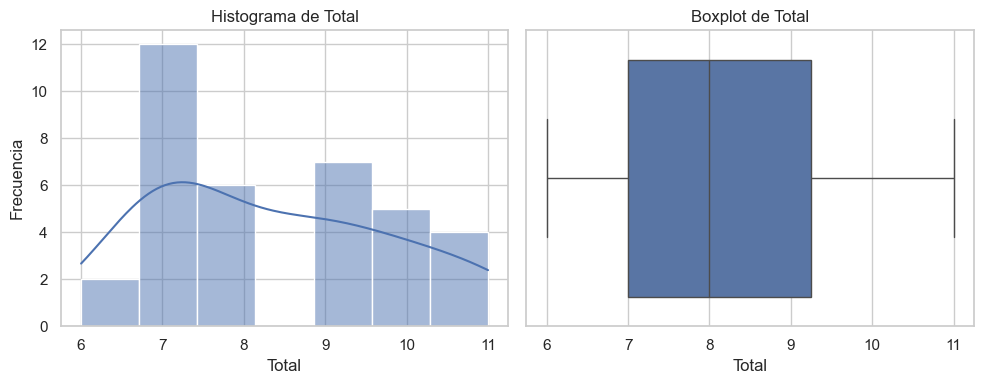

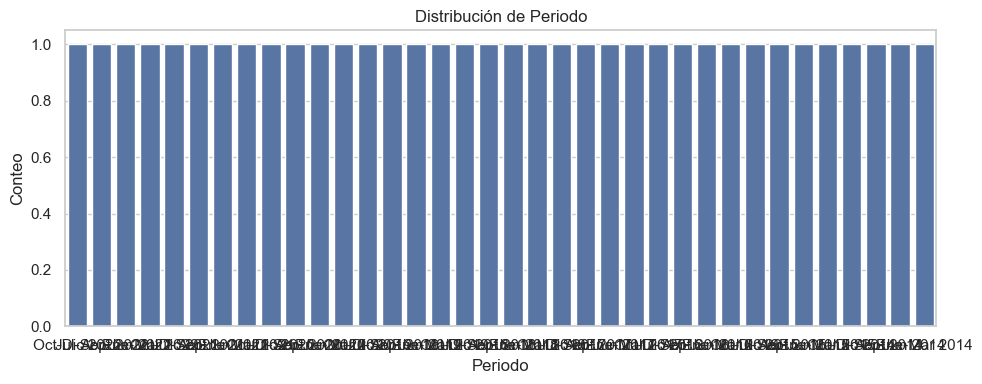

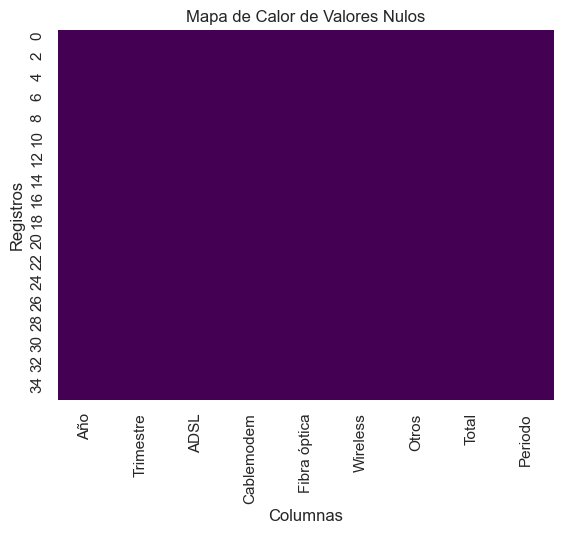

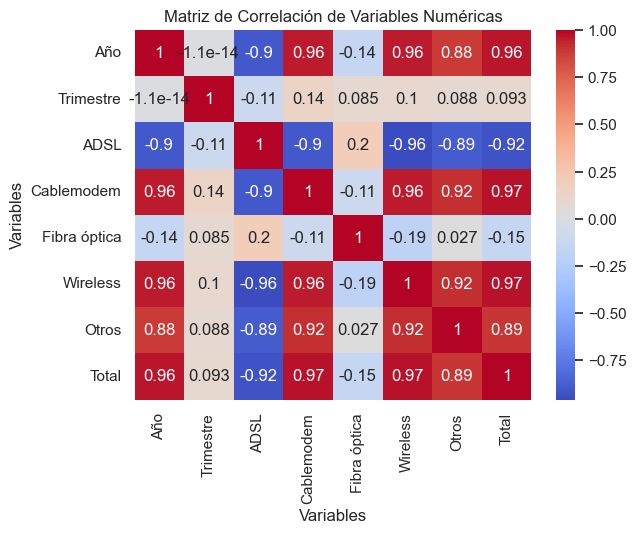

##################################################


In [85]:
informacion_dataframe('Serie Trimestral por Tecnología', df_serie_trimestral_tecnologia, visualizar=True, muestras=None, interactividad=True)

- **Tendencias Generales**:
  - La tecnología Wireless ha ido incrementando su presencia a lo largo de los años, como se puede observar en la subida de sus valores desde 2014 hasta 2022.
  - La Fibra Óptica tuvo un pico significativo en 2019, pero sus números han bajado o se han mantenido estables en otras entradas, lo que podría requerir una investigación más profunda para entender las razones de esta fluctuación.

- **Consistencia y Compleción de Datos**:
  - El DataFrame está completo y no presenta valores nulos ni filas duplicadas, lo que sugiere que los datos están limpios y son confiables para un análisis más detallado.
  - Hay una consistencia en el número de registros por trimestre y año, lo que facilita análisis temporales y comparativos.

- **Variabilidad y Distribución**:
  - Existe una alta variabilidad en la categoría de 'Fibra óptica' y 'Wireless', lo cual es indicativo de cambios significativos en el uso o la adopción de estas tecnologías a lo largo del tiempo.
  - Los 'Otros' métodos de conexión también muestran una variabilidad considerable, lo que podría sugerir cambios en la popularidad o disponibilidad de tecnologías alternativas.

- **Cambios y Puntos de Inflexión**:
  - El año 2019 muestra un cambio significativo para la Fibra Óptica, lo que podría corresponder a una campaña de expansión o a cambios en las políticas de infraestructura tecnológica.
  - Entre 2018 y 2022, se observa una tendencia al aumento de la tecnología Wireless, que puede estar relacionada con la mejora en la cobertura y la adopción de tecnologías móviles.

- **ADSL y Cablemodem**:
  - Las tecnologías ADSL y Cablemodem parecen tener números consistentemente bajos a lo largo del tiempo, lo que puede indicar su progresiva obsolescencia o reemplazo por opciones de conexión más modernas.


La matriz de correlación proporciona información valiosa sobre cómo las distintas tecnologías de conexión a Internet y los años están relacionados entre sí:

- **Relación con el Año**:
  - **ADSL**: Existe una correlación negativa fuerte (-0.9) con el año, lo que indica que la presencia de ADSL ha disminuido significativamente a lo largo del tiempo.
  - **Cablemodem y Wireless**: Ambos tienen una correlación positiva fuerte (0.96) con el año, sugiriendo que su uso ha aumentado a medida que avanzan los años.
  - **Fibra Óptica**: La correlación es débilmente negativa (-0.14) con el año, lo cual es curioso ya que se esperaría que la fibra óptica estuviera en aumento. Esto podría ser un indicio de que hubo un auge en un año específico, como se mencionó anteriormente, pero no ha habido un crecimiento sostenido a lo largo del tiempo.

- **Relación entre Tecnologías**:
  - **ADSL y Cablemodem**: La correlación negativa fuerte (-0.9) sugiere que a medida que el ADSL disminuye, el cablemodem aumenta, lo que puede indicar una sustitución directa entre estas tecnologías.
  - **ADSL y Wireless**: Una correlación negativa muy fuerte (-0.96) indica que el aumento de la tecnología inalámbrica podría estar directamente relacionado con la disminución del ADSL.
  - **Cablemodem y Wireless**: La correlación positiva fuerte (0.96) sugiere que estas dos tecnologías han tendido a aumentar juntas. Dado que ambas son formas de acceso a Internet de banda ancha, esto podría reflejar un movimiento general hacia conexiones de alta velocidad.

- **Otros Hallazgos**:
  - La correlación entre 'Otros' y tecnologías como Wireless y Cablemodem es alta (0.92), lo que podría indicar que a medida que aumentan estas tecnologías, también lo hace la categoría 'Otros', que podría incluir tecnologías emergentes o menos comunes.
  - La correlación entre 'Fibra Óptica' y otras tecnologías es generalmente baja, lo que sugiere que su adopción no está fuertemente ligada al comportamiento de otras tecnologías en este conjunto de datos.
  - La correlación entre 'Total' y tecnologías como Cablemodem, Wireless y 'Otros' es muy alta (0.89 a 0.97), lo que implica que el crecimiento total de accesos a Internet está siendo impulsado principalmente por estas tecnologías.

#### Gráficos de líneas múltiples para mostrar la evolución de ADSL, Cablemodem, Wireless y Fibra óptica por trimestre.

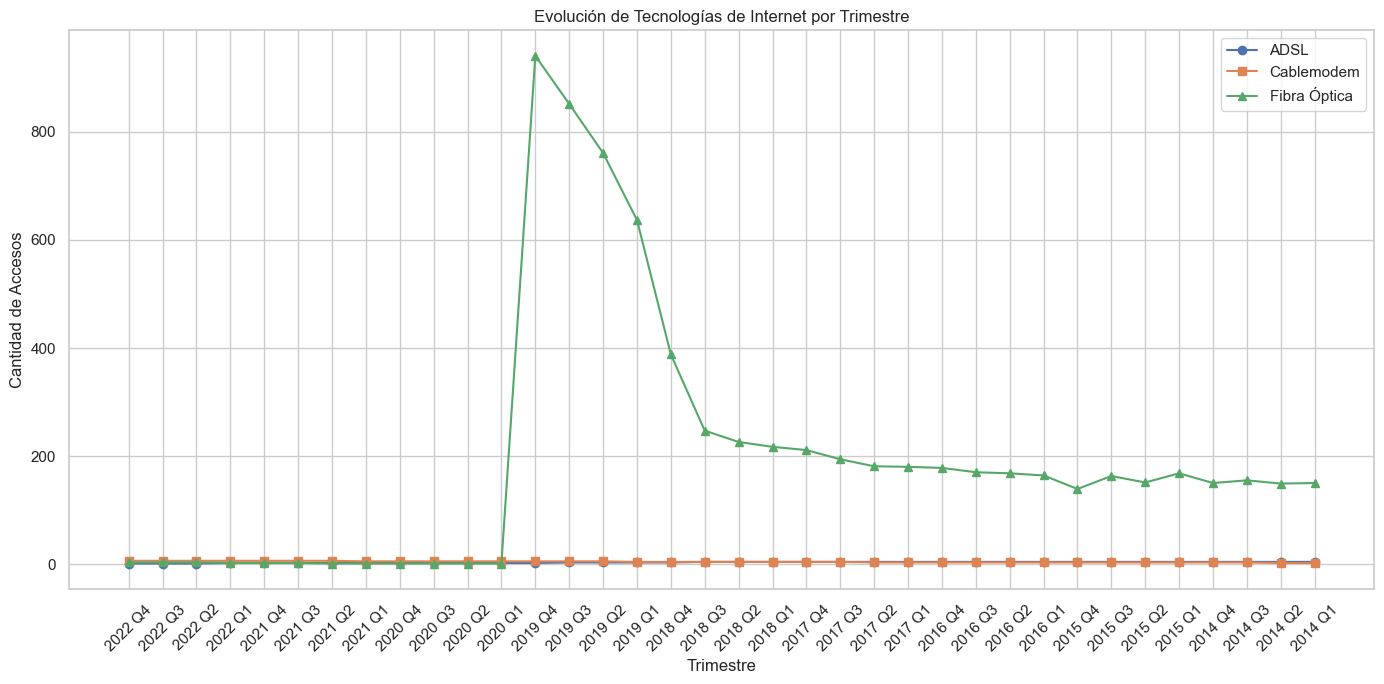

In [86]:
# Crear una nueva columna 'Periodo' que combine 'Año' y 'Trimestre' para una mejor visualización en el eje X.
df_serie_trimestral_tecnologia['Periodo'] = df_serie_trimestral_tecnologia['Año'].astype(str) + ' Q' + df_serie_trimestral_tecnologia['Trimestre'].astype(str)

# Establecer la columna 'Periodo' como el índice del DataFrame para el eje X del gráfico.
df_serie_trimestral_tecnologia.set_index('Periodo', inplace=True)

# Seleccionar las columnas de tecnología que quieres graficar.
df_tecnologias = df_serie_trimestral_tecnologia[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless']]

# Graficar las líneas para cada tecnología.
plt.figure(figsize=(14, 7))
plt.plot(df_tecnologias.index, df_tecnologias['ADSL'], label='ADSL', marker='o')
plt.plot(df_tecnologias.index, df_tecnologias['Cablemodem'], label='Cablemodem', marker='s')
plt.plot(df_tecnologias.index, df_tecnologias['Fibra óptica'], label='Fibra Óptica', marker='^')

# Añadir título y etiquetas a los ejes.
plt.title('Evolución de Tecnologías de Internet por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Cantidad de Accesos')

# Rotar las etiquetas del eje X para una mejor visualización.
plt.xticks(rotation=45)

# Añadir una leyenda para identificar cada línea.
plt.legend()

# Mostrar una cuadrícula para facilitar la lectura de los valores.
plt.grid(True)

# Mostrar el gráfico.
plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama para dar un padding alrededor de la figura.
plt.show()


In [87]:
df_tecnologias

ADSL  Cablemodem  Fibra óptica
Periodo                                
2022 Q4     1           6             3
2022 Q3     1           6             3
2022 Q2     1           6             3
2022 Q1     2           6             2
2021 Q4     2           6             2
2021 Q3     2           6             2
2021 Q2     2           6             1
2021 Q1     2           5             1
2020 Q4     2           5             1
2020 Q3     2           5             1
2020 Q2     2           5             1
2020 Q1     2           5             1
2019 Q4     2           5           941
2019 Q3     3           5           852
2019 Q2     3           5           761
2019 Q1     3           4           637
2018 Q4     3           4           388
2018 Q3     4           4           247
2018 Q2     4           4           226
2018 Q1     4           4           217
2017 Q4     4           4           211
2017 Q3     4           4           194
2017 Q2     4           3           181
2017 Q1     4           3           180
2016 Q4     4           3           178
2016 Q3     4           3           170
2016 Q2     4           3           168
2016 Q1     4           3           164
2015 Q4     4           3           139
2015 Q3     4           3           163
2015 Q2     4           3           151
2015 Q1     4           3           168
2014 Q4     4           3           150
2014 Q3     4           3           155
2014 Q2     4           2           149
2014 Q1     4           2           150